# 5510 Final Project - Unsupervised Learning on Country Data

Kaggle: https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data?utm_source=chatgpt.com&select=Country-data.csv


## 1) Project Setup

In [108]:
# System stuff
import os
import sys
from pathlib import Path

# Basic data science
import random
import numpy as np
import pandas as pd
import math
import statsmodels.api as sm

import kagglehub   # need this to download dataset

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.cluster import KMeans
%matplotlib inline

# Scikit-learn (including 3 or 4 that I didn't end up keeping in the final code.
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer


from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_selection import chi2
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from wordcloud import WordCloud
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay,
    mean_squared_error, mean_absolute_error, r2_score,
    f1_score, accuracy_score, precision_score, recall_score, 
    silhouette_score, calinski_harabasz_score, davies_bouldin_score
)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# helper function to delimit sections in data output
def section_split(width=160, char="-"):
    print("\n", char * width, "\n")

# Plotting defaults
sns.set_theme(
    context="notebook",
    style="darkgrid",
    palette="deep"
)
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 300,
    "axes.titlesize": 12,
    "axes.labelsize": 10
})

# helper function to save figures
def save_figure(name=None, dpi=300, bbox_inches='tight', pad_inches=0.1):
    # Create directory if it doesn't exist
    save_dir = "figs/5510_mini_project"
    os.makedirs(save_dir, exist_ok=True)
    # Generate filename
    if name is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"chart_{timestamp}.png"
    else:
        # Clean the name to be filename-safe
        filename = "".join(c for c in name if c.isalnum() or c in (' ', '-', '_')).rstrip()
        filename = filename.replace(' ', '_')
        if not filename.endswith('.png'):
            filename += '.png'
    # Full path
    filepath = os.path.join(save_dir, filename)
    # Save the figure
    plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches, pad_inches=pad_inches)
    print(f"Figure saved: {filepath}")
    return filepath

def setup_plot_grid(n=9):
    if n < 5:
        n_cols = 2
    if n > 9:
        n_cols = 4
    else:
        n_cols = 3
    n_rows = math.ceil(n / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 3.5), constrained_layout=True)
    axes = np.array(axes).reshape(-1)  # flatten in case of single row/col
    return fig, axes

def plot_hist(data, num_cols=None, filename="histograms"):
    if num_cols is None:
        num_cols = data.select_dtypes(include=["int", "float"]).columns.tolist()

    fig, axes = setup_plot_grid(len(num_cols))

    for i, col in enumerate(num_cols):
        ax = axes[i]
        sns.histplot(country_data[col].dropna(), bins=30, kde=True, ax=ax)
        ax.set_title(col)
        ax.set_xlabel("")
        ax.set_ylabel("Count")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle("Distributions of Numeric Features")
    save_figure(filename)
    plt.show()
    return

def plot_outliers(data, num_cols=None, filename="outliers"):
    if num_cols is None:
        num_cols = data.select_dtypes(include=["int", "float"]).columns.tolist()

    fig, axes = setup_plot_grid(len(num_cols))
    colours = sns.color_palette(n_colors=len(num_cols))


    for i, col in enumerate(num_cols):
        ax = axes[i]
        sns.boxplot(x = data[col], ax=ax, color=colours[i])
        box_title = f"{col} , mean = {data[col].mean():.1f}, std_dev = {data[col].std():.1f}"
        ax.set_title(box_title)
        ax.set_xlabel("")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle("Outliers for Numeric Features")
    save_figure(filename)
    plt.show()
    return

def identify_outliers_by_iqr(data, column, multiplier=1.5):
    """
    Identify outliers using the IQR method (same method used by boxplots).
    Returns a DataFrame of outlier rows and their values.
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Find outliers
    outliers_mask = (data[column] < lower_bound) | (data[column] > upper_bound)
    outliers_df = data[outliers_mask][['country', column]].copy()
    outliers_df['outlier_type'] = 'extreme_low'
    outliers_df.loc[data[column] > upper_bound, 'outlier_type'] = 'extreme_high'

    return outliers_df.sort_values(column)

def identify_all_outliers(data, num_cols=None):
    """
    Identify outliers for all numeric columns and display results.
    """
    if num_cols is None:
        num_cols = data.select_dtypes(include=["int", "float"]).columns.tolist()

    all_outliers = {}

    for col in num_cols:
        outliers = identify_outliers_by_iqr(data, col)
        if not outliers.empty:
            all_outliers[col] = outliers
            print(f"\n=== Outliers for {col} ===")
            print(f"Total outliers: {len(outliers)}")
            print(outliers.to_string(index=False))
        else:
            print(f"\n=== No outliers found for {col} ===")

    return all_outliers


# Method to get the row indices (useful for further analysis)
def get_outlier_indices(data, column):
    """
    Get the DataFrame indices of outlier rows for a specific column.
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_mask = (data[column] < lower_bound) | (data[column] > upper_bound)
    outlier_indices = data[outliers_mask].index.tolist()

    return outlier_indices

def null_nans(data):
    missing = 0
    for col in data.columns:
        nulls = data[col].isnull().sum()
        nans = data[col].isna().sum()
        if nulls > 0:
            print(f"Column '{col}' has {nulls} null values.")
            missing += nulls
        if nans > 0:
            print(f"Column '{col}' has {nans} NaN values.")
            missing += nans
    print(f"Total missing values (NaNs or Nulls): {missing}")
    return

print("Python:", sys.version.split()[0])
print("Pandas:", pd.__version__)

Python: 3.11.13
Pandas: 2.3.2


### Load Data

In [100]:
# Set flag to determine if we get the latest version from Kaggle
use_cache = True

if use_cache:
    path = "/Users/seancoffey/.cache/kagglehub/datasets/rohan0301/unsupervised-learning-on-country-data/versions/2"
else:
    # Download latest version
    path = kagglehub.dataset_download("rohan0301/unsupervised-learning-on-country-data")
    # print("Path to dataset files:", path)

p = Path(path)
files = [f.name for f in p.iterdir() if f.is_file()]
print("Files in folder:")
for name in files:
    print("-", name)

csv_files = sorted(p.rglob("*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found under {p}")
country_data = pd.read_csv(csv_files[0])
data_dict = pd.read_csv(csv_files[1])
print("Loaded:", csv_files[0].name, country_data.shape)
print("Loaded:", csv_files[1].name, data_dict.shape)
display(country_data.head())
display(data_dict)

Files in folder:
- data-dictionary.csv
- Country-data.csv
Loaded: Country-data.csv (167, 10)
Loaded: data-dictionary.csv (10, 2)


country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200

Column Name                                        Description
0     country                                Name of the country
1  child_mort  Death of children under 5 years of age per 100...
2     exports  Exports of goods and services per capita. Give...
3      health  Total health spending per capita. Given as %ag...
4     imports  Imports of goods and services per capita. Give...
5      Income                              Net income per person
6   Inflation  The measurement of the annual growth rate of t...
7  life_expec  The average number of years a new born child w...
8   total_fer  The number of children that would be born to e...
9        gdpp  The GDP per capita. Calculated as the Total GD...

## 2) Exploratory Data Analysis

child_mort     exports      health     imports         income  \
count  167.000000  167.000000  167.000000  167.000000     167.000000   
mean    38.270060   41.108976    6.815689   46.890215   17144.688623   
std     40.328931   27.412010    2.746837   24.209589   19278.067698   
min      2.600000    0.109000    1.810000    0.065900     609.000000   
25%      8.250000   23.800000    4.920000   30.200000    3355.000000   
50%     19.300000   35.000000    6.320000   43.300000    9960.000000   
75%     62.100000   51.350000    8.600000   58.750000   22800.000000   
max    208.000000  200.000000   17.900000  174.000000  125000.000000   

        inflation  life_expec   total_fer           gdpp  
count  167.000000  167.000000  167.000000     167.000000  
mean     7.781832   70.555689    2.947964   12964.155689  
std     10.570704    8.893172    1.513848   18328.704809  
min     -4.210000   32.100000    1.150000     231.000000  
25%      1.810000   65.300000    1.795000    1330.000000  
50%      5.390000   73.100000    2.410000    4660.000000  
75%     10.750000   76.800000    3.880000   14050.000000  
max    104.000000   82.800000    7.490000  105000.000000

Check for duplicates: 0
Total missing values (NaNs or Nulls): 0

 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

Figure saved: figs/5510_mini_project/histograms.png


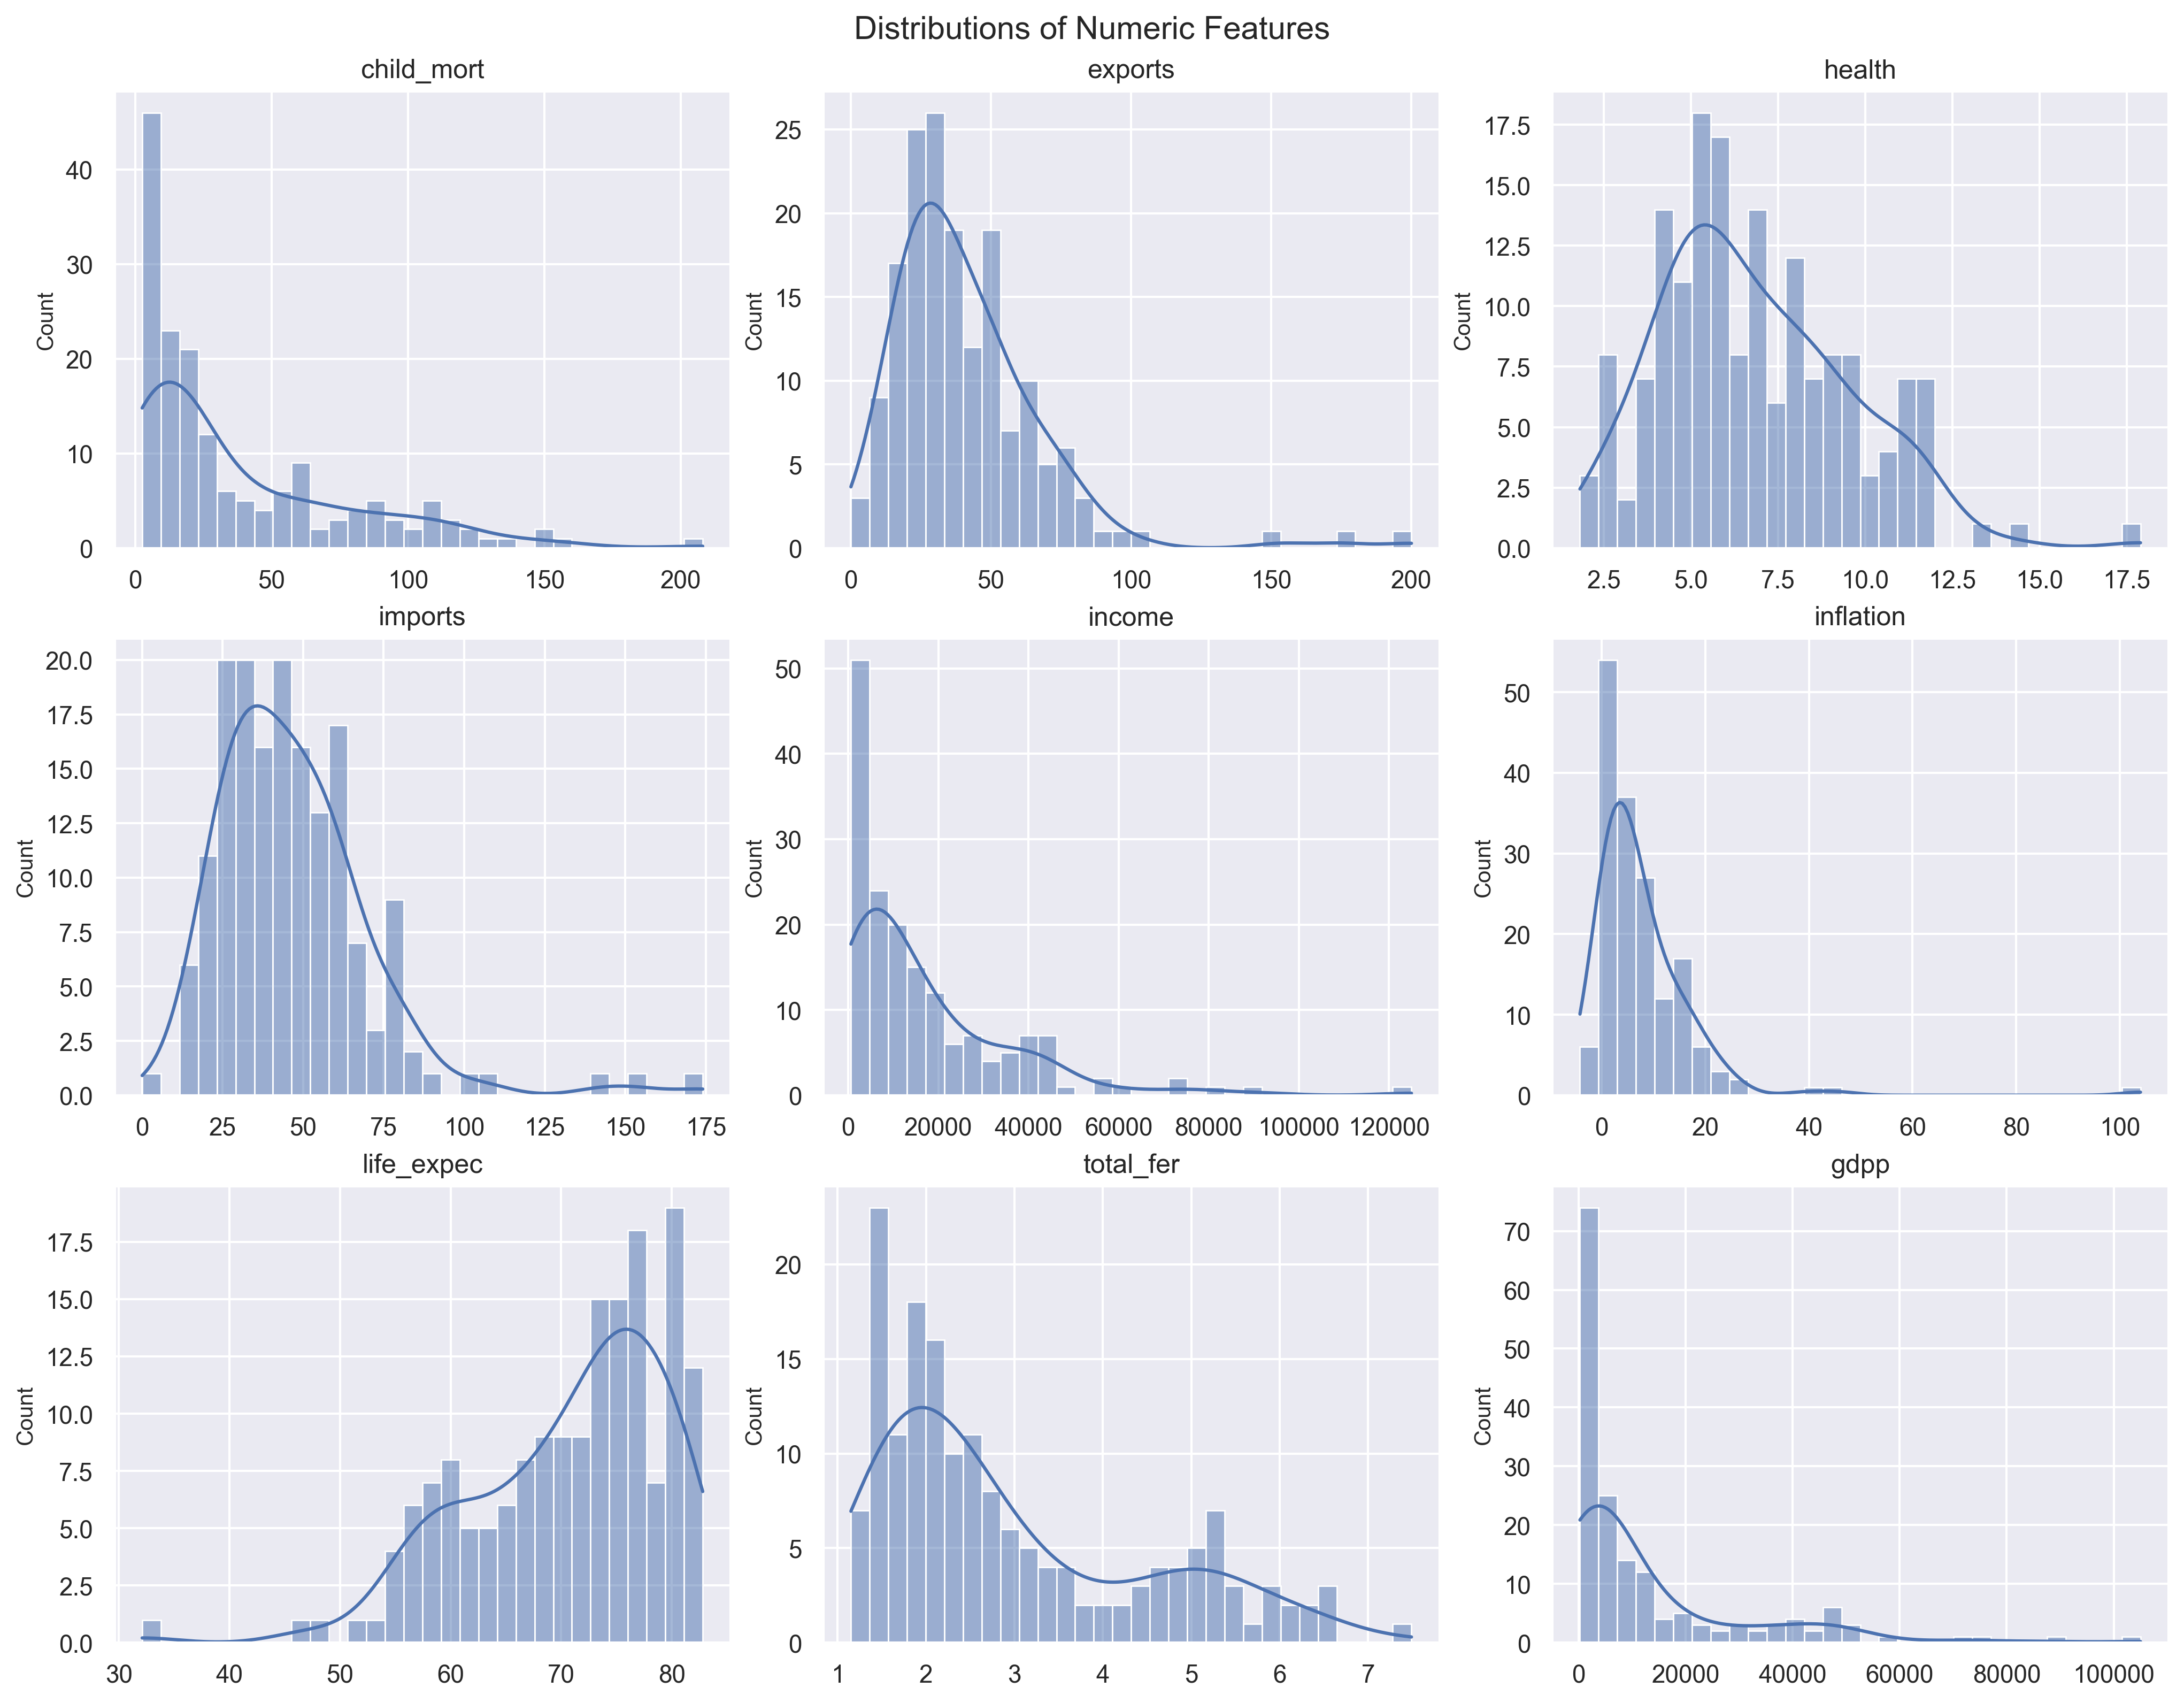


 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

Figure saved: figs/5510_mini_project/num_cols_corr.png


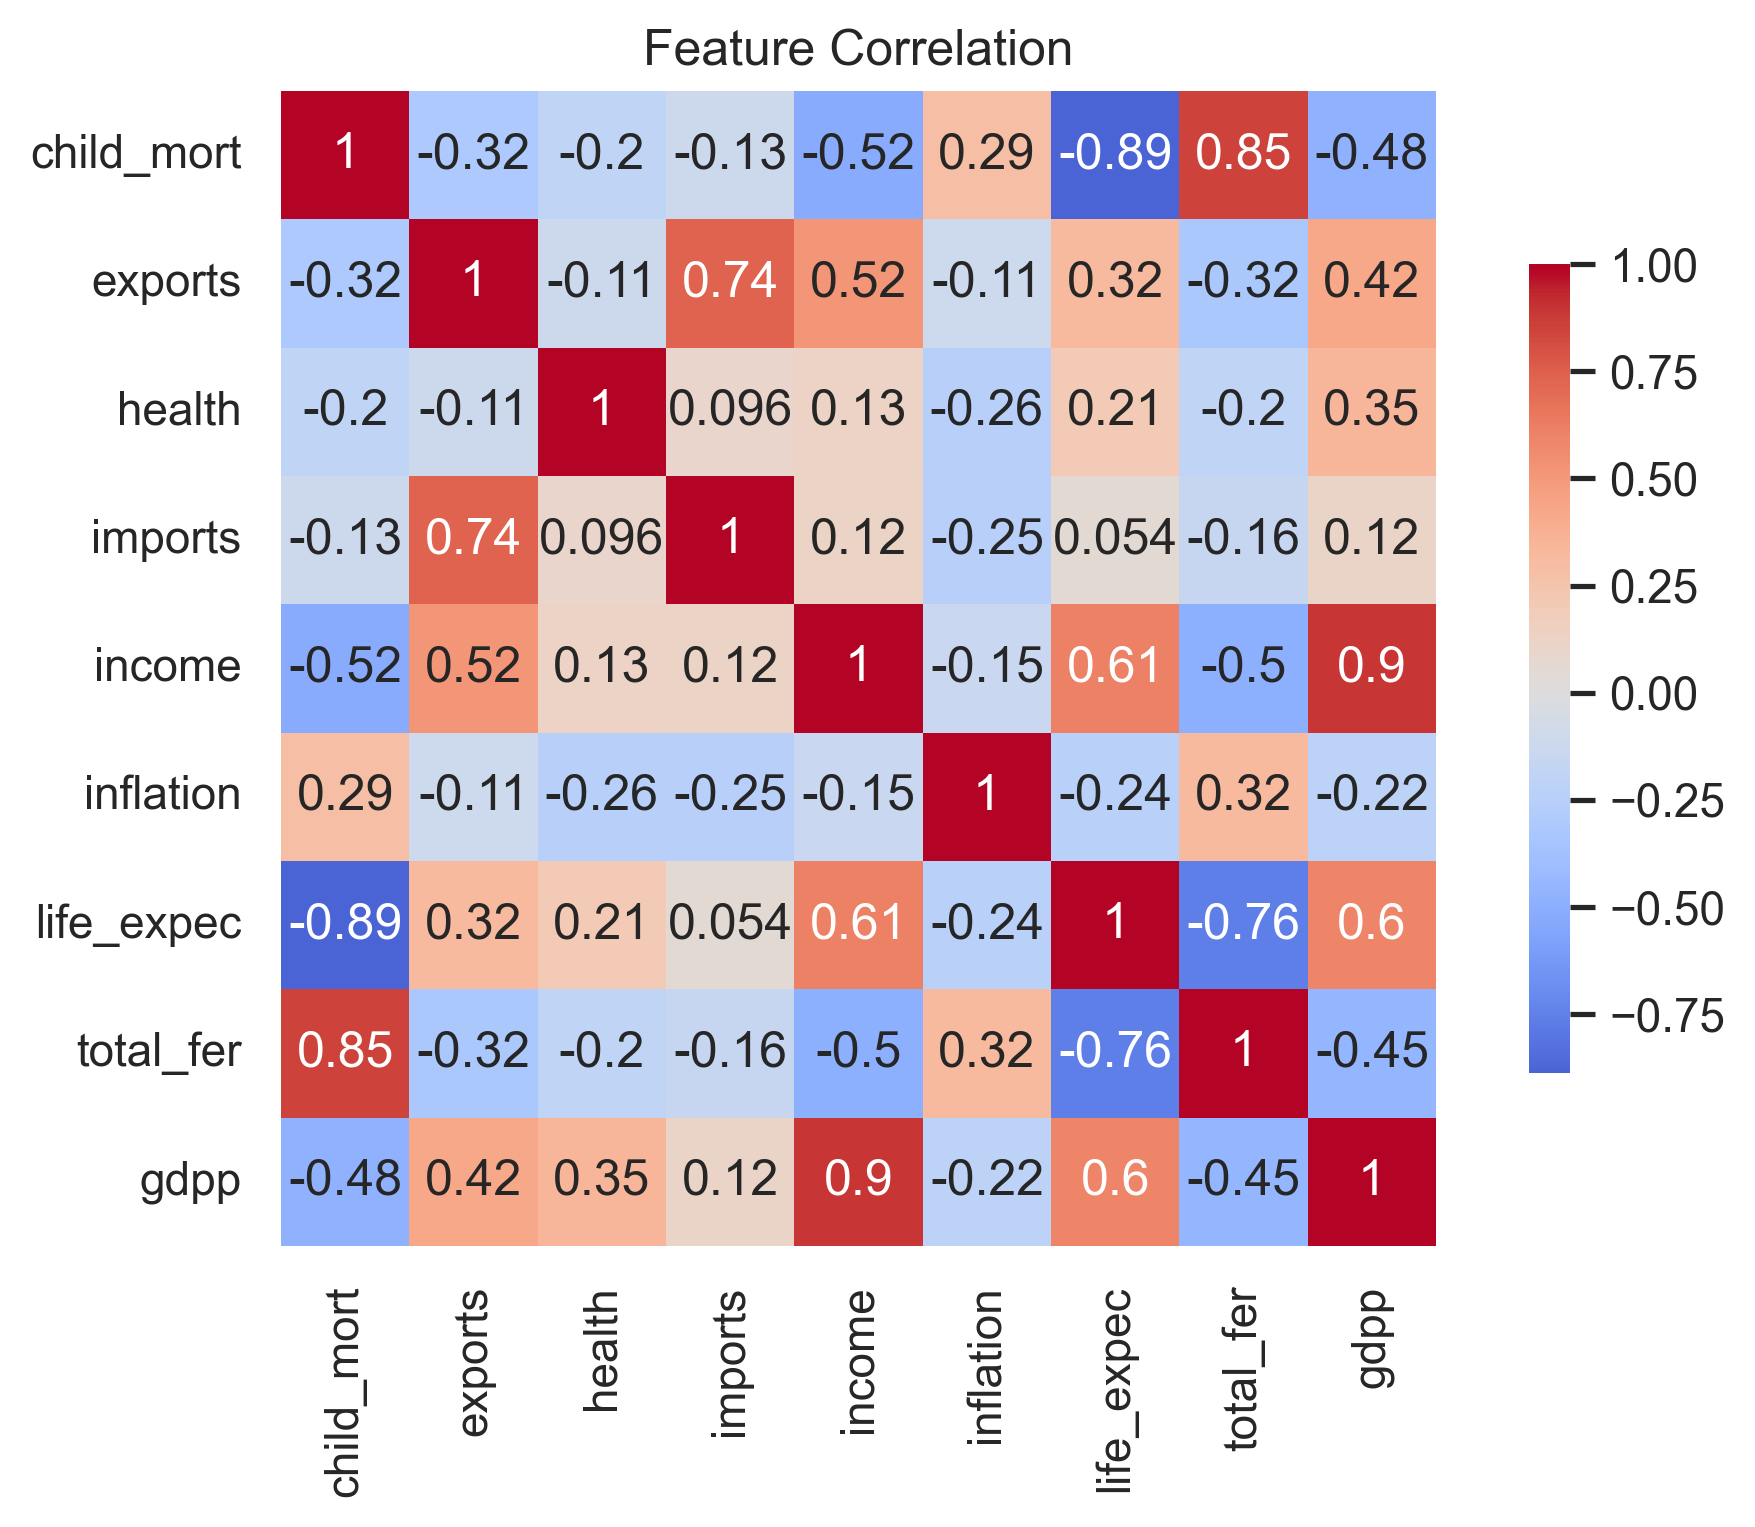


 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

Figure saved: figs/5510_mini_project/outliers.png


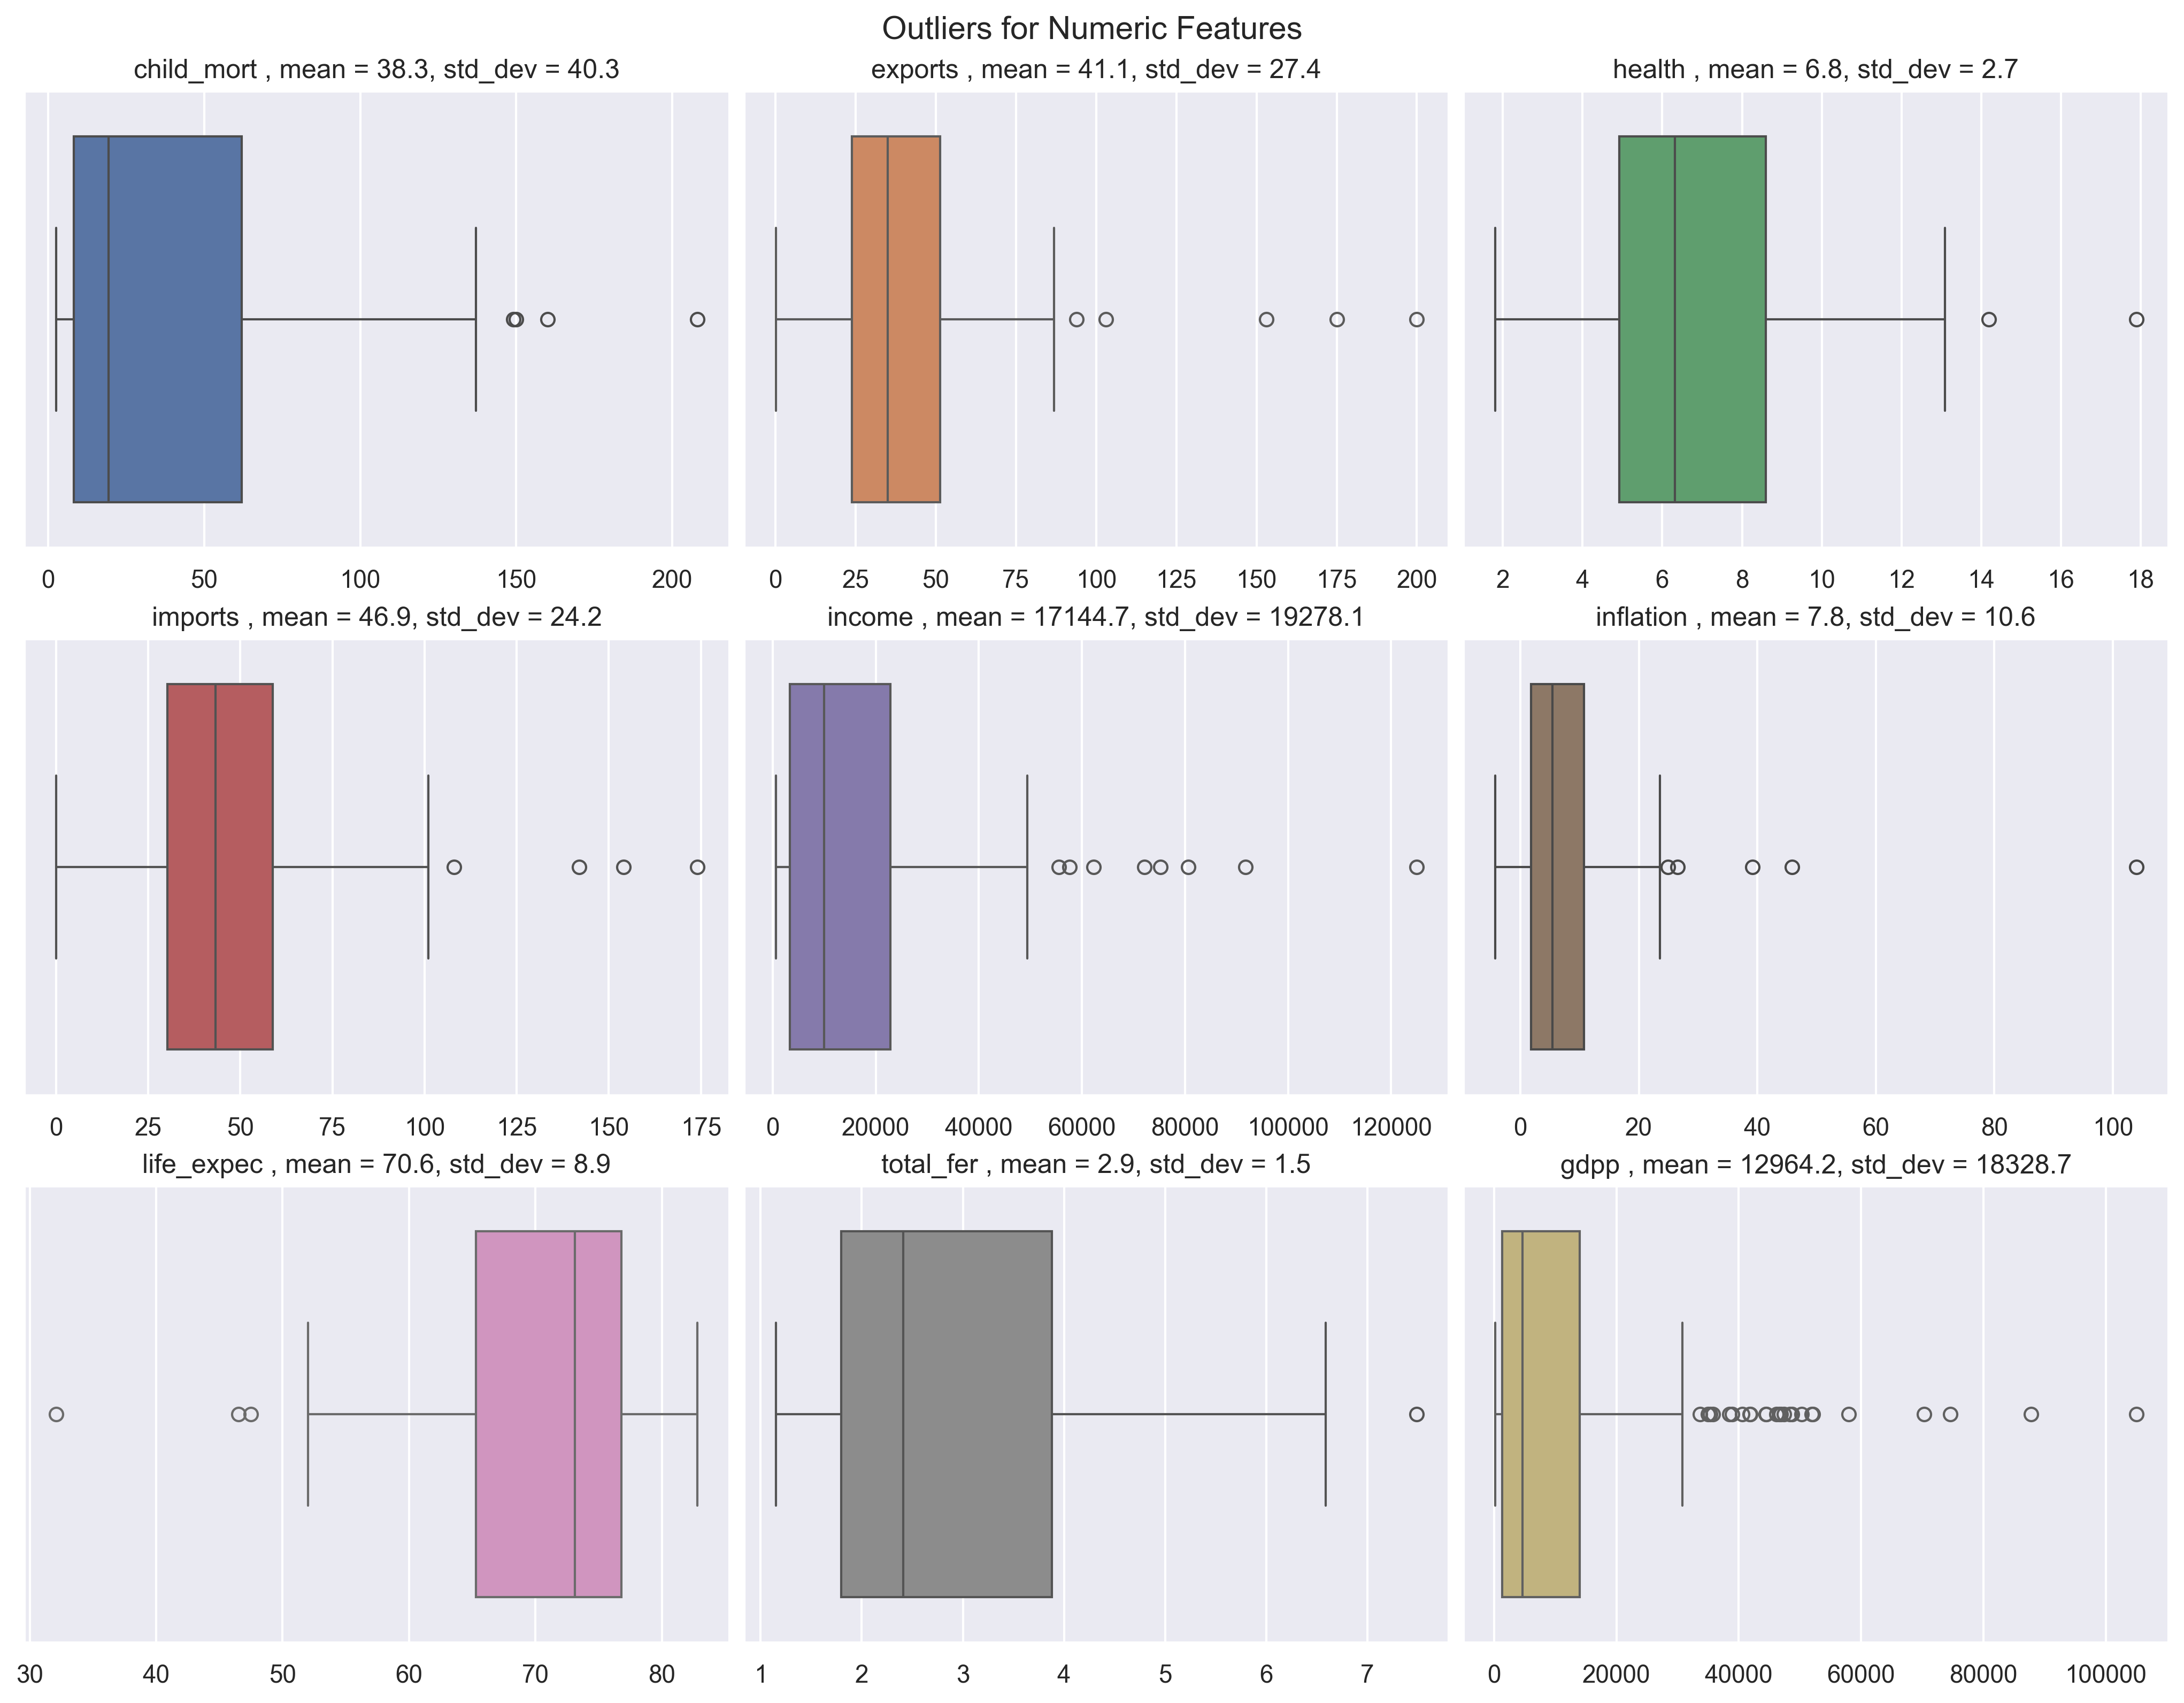


=== Outliers for child_mort ===
Total outliers: 4
                 country  child_mort outlier_type
Central African Republic       149.0 extreme_high
                    Chad       150.0 extreme_high
            Sierra Leone       160.0 extreme_high
                   Haiti       208.0 extreme_high

=== Outliers for exports ===
Total outliers: 5
   country  exports outlier_type
Seychelles     93.8 extreme_high
   Ireland    103.0 extreme_high
     Malta    153.0 extreme_high
Luxembourg    175.0 extreme_high
 Singapore    200.0 extreme_high

=== Outliers for health ===
Total outliers: 2
              country  health outlier_type
Micronesia, Fed. Sts.    14.2 extreme_high
        United States    17.9 extreme_high

=== Outliers for imports ===
Total outliers: 4
   country  imports outlier_type
Seychelles    108.0 extreme_high
Luxembourg    142.0 extreme_high
     Malta    154.0 extreme_high
 Singapore    174.0 extreme_high

=== Outliers for income ===
Total outliers: 8
             coun

In [101]:
# list the numeric columnds
num_cols = country_data.select_dtypes(include=["int", "float"]).columns.tolist()

## BASE EDA Information
display(country_data.describe())
print(f'Check for duplicates: {country_data.duplicated().sum()}')
null_nans(country_data)
section_split()

# Start with a simple pairplot - decided not to for this dataset, didn't add much value
## sns.pairplot(country_data, vars=num_cols, diag_kind="kde")
## save_figure("num_cols_pairplot")
## plt.show()

# Distributions
plot_hist(country_data)
section_split()

# Correlation heatmap
corr = country_data[num_cols].corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, annot=True, cbar_kws={"shrink": 0.7})
plt.title("Feature Correlation")
save_figure("num_cols_corr")
plt.show()
section_split()

# Outlier Analysis
plot_outliers(country_data)
outlier_results = identify_all_outliers(country_data)
section_split()

### EDA observations

We haven't got an issue with missing values, NaNs, nulls or duplicates.

There are very different units and scales across the features. Almost certaily, some form of normalization, min-max scaling will be needed as part of pre-processing.

The distributions of 'child_mort', 'income', 'gdpp' are heavily skewed towards zero. LIfe-expectancy is the only feature with a distribution skewed towards its maximum value.

**Correlations > 0.7**
- Life expectancy is negatively correlated with Child Mortality
- Child Mortality is positively correlated with Fertility Rate
- Income is positvely correlated with gdp per person
- Eports and imports are positively correlated
- Fertilisation rate and life expectancy are negsatively correlated

#### Outliers

There are a number of extreme outliers (in nearly all features) which may impact clustering. In particular, considering that I was intending to use a combination of PCA and k-Means Clustering, potential issues are:
1. **PCA distortion**: Outliers can dominate principal components, causing them to point toward extreme values rather than capturing true data variance
2. **Cluster centroid skewing**: K-means centroids get pulled toward outliers, creating poorly separated clusters
3. **Distance metric issues**: K-means uses Euclidean distance, which is sensitive to extreme values

**Potential Solutios to Investigate**
1. Use RobustScaler instead of StandardScaler or MInMaxScaler (works with median and IQR instead of mean and std or min and max respectively.)
2. Remove extreme outliers. For example, those with 3+ standard deviations. May not be representative of the data, so I will avoid this approach.
3. Winsorisation - Cap outliers at reasonable percentiles (e.g., 5th and 95th percentiles)
4. Log transformation - Could apply to heavily skewed features like income, gdpp
5. Alternative clustering approaches that are less sensitive to outliers: DBSCAN or Hierarchical clustering with robust linkage

**Note:** As I am uncertain of the impact of 3. Winssorisation, so I will create two versions of the data one with Winsorisation and one without. Then compare the cluster quality (scoring to be determined).

## 3) Preprocessing

In [61]:
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=None, feature_limits=None):
        """
        limits: default limits for all features
        feature_limits: dict mapping feature indices to specific limits
        """
        self.limits = limits or (0.05, 0.05)
        self.feature_limits = feature_limits or {}
        self.bounds_ = {}

    def fit(self, X, y=None):
        for i in range(X.shape[1]):
            # Use feature-specific limits if provided, otherwise use default
            current_limits = self.feature_limits.get(i, self.limits)
            lower_bound = np.percentile(X[:, i], current_limits[0] * 100)
            upper_bound = np.percentile(X[:, i], (1 - current_limits[1]) * 100)
            self.bounds_[i] = (lower_bound, upper_bound)
        return self

    def transform(self, X):
        X_winsorized = X.copy()
        for i in range(X.shape[1]):
            lower_bound, upper_bound = self.bounds_[i]
            X_winsorized[:, i] = np.clip(X_winsorized[:, i], lower_bound, upper_bound)
        return X_winsorized


Comparison of outliers for scaler_A and scaler_B:

Figure saved: figs/5510_mini_project/outliers.png


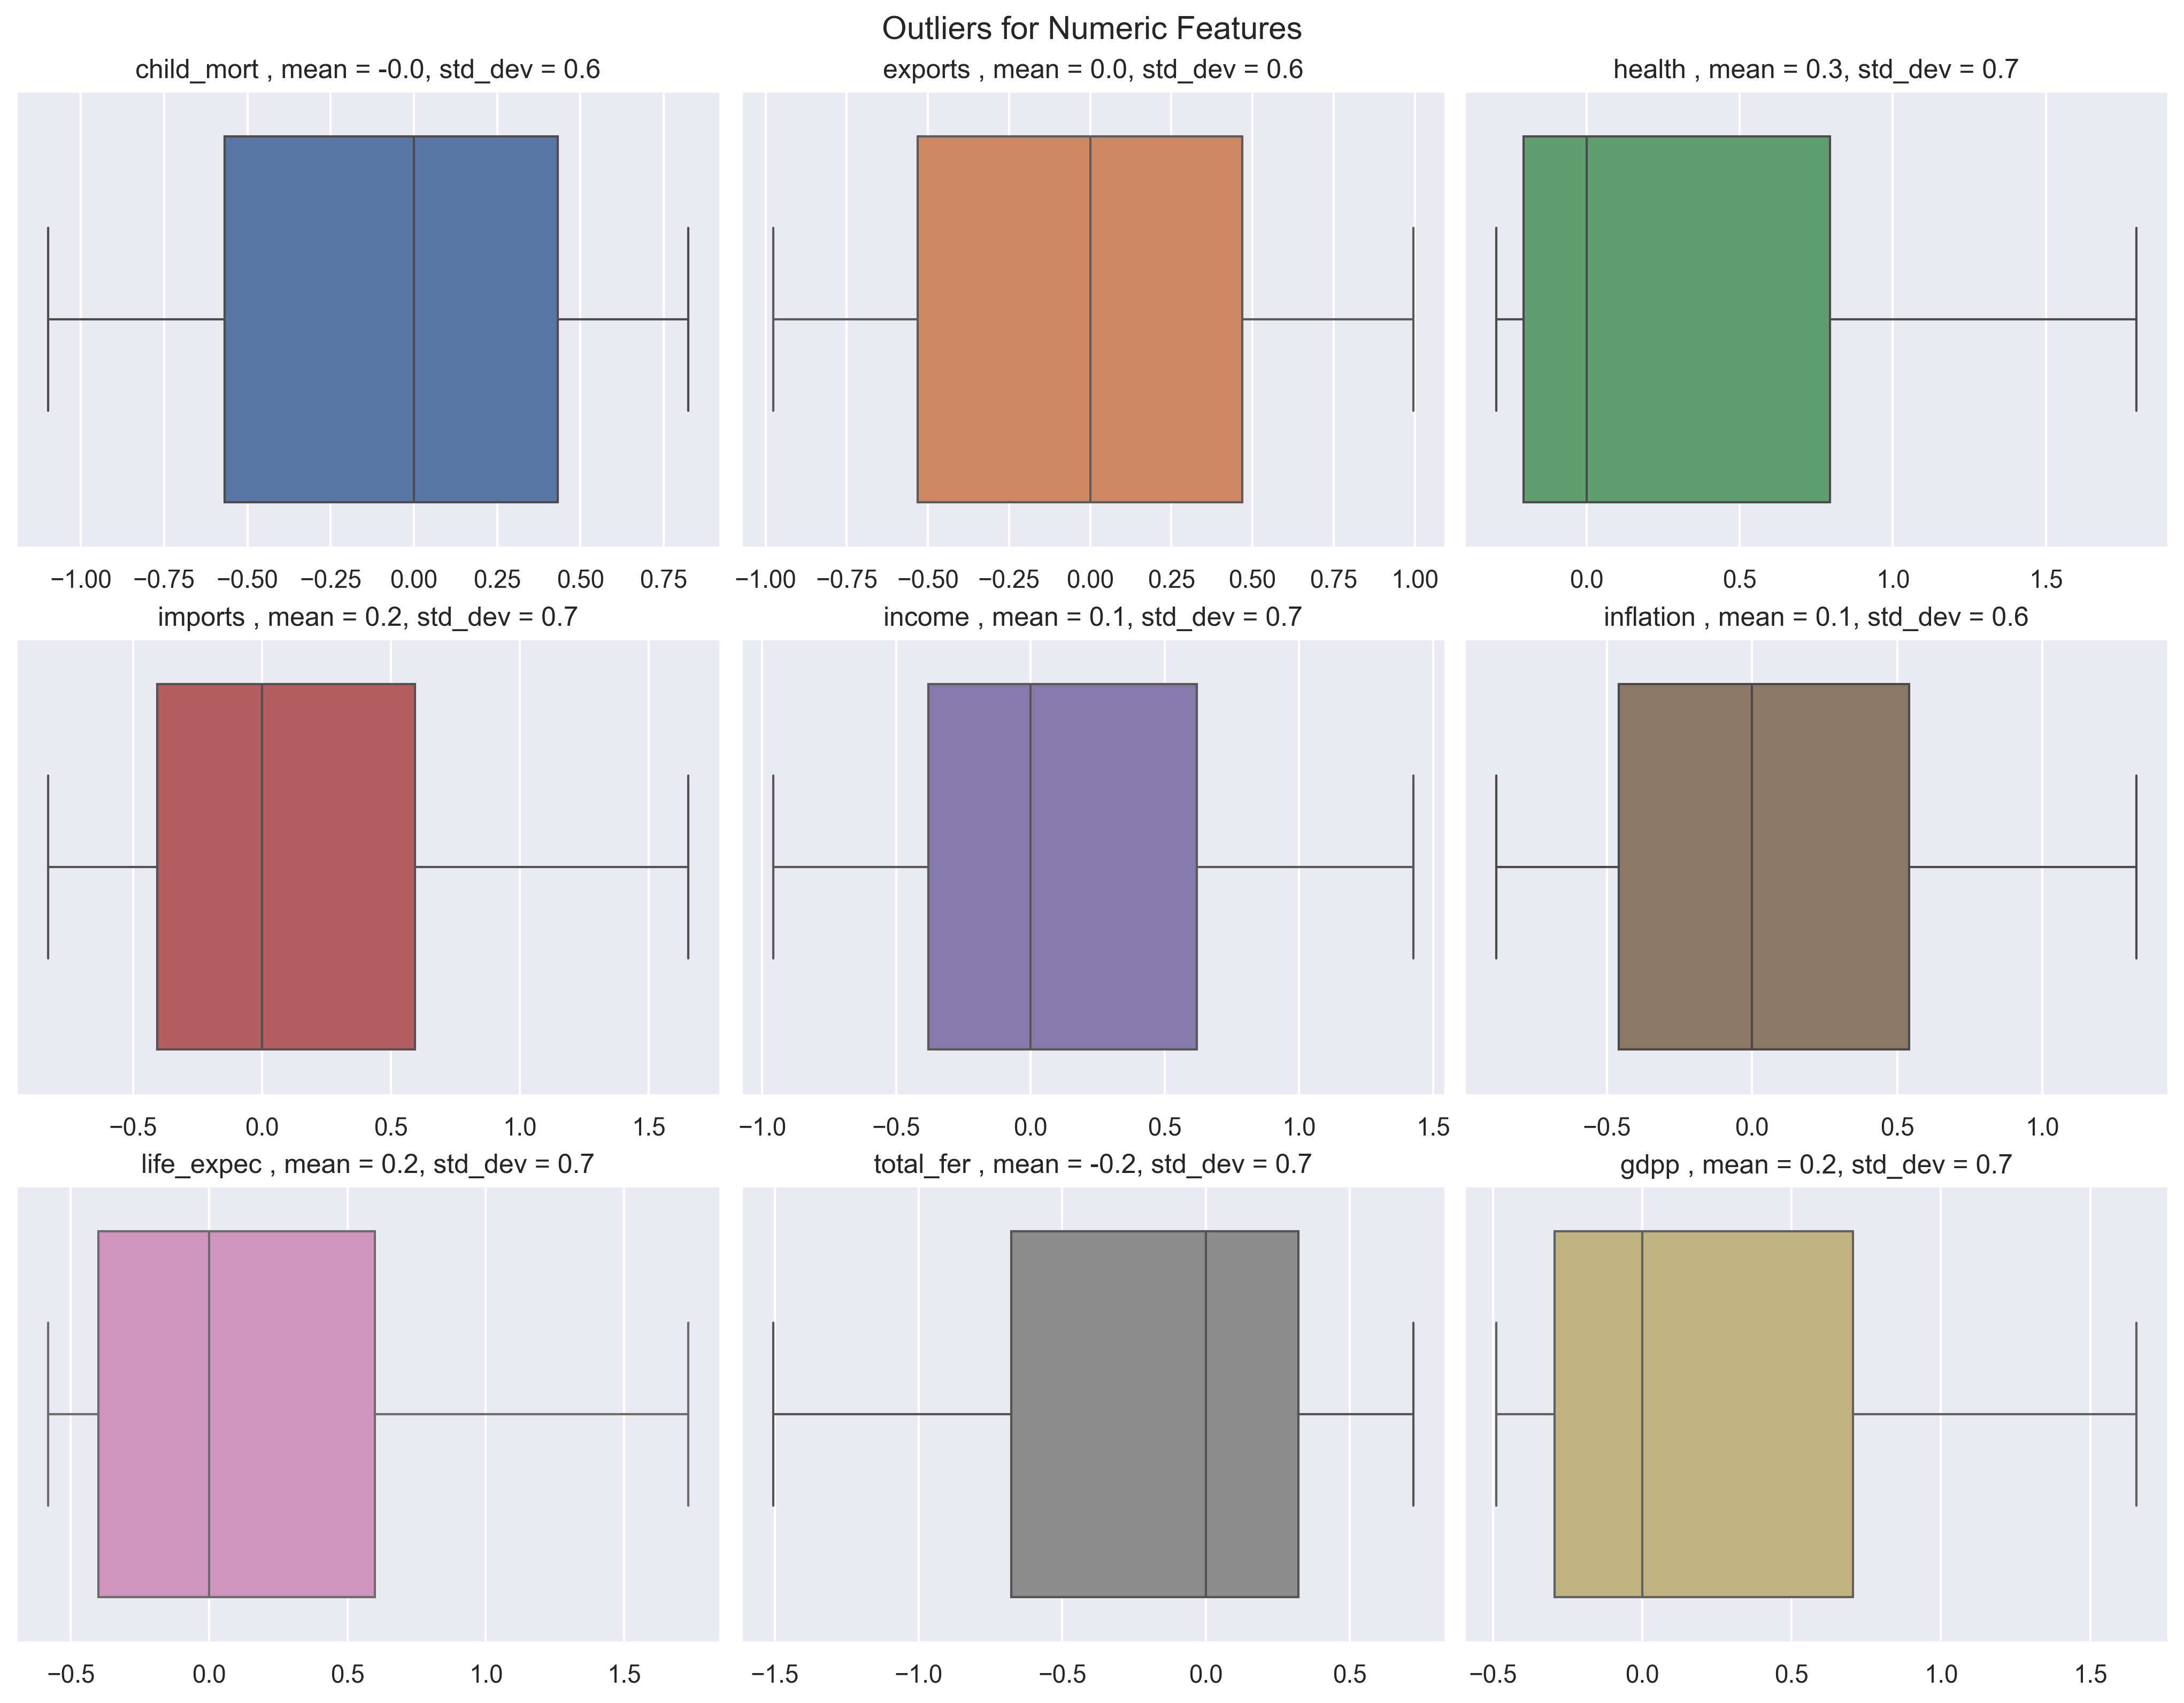

Figure saved: figs/5510_mini_project/outliers.png


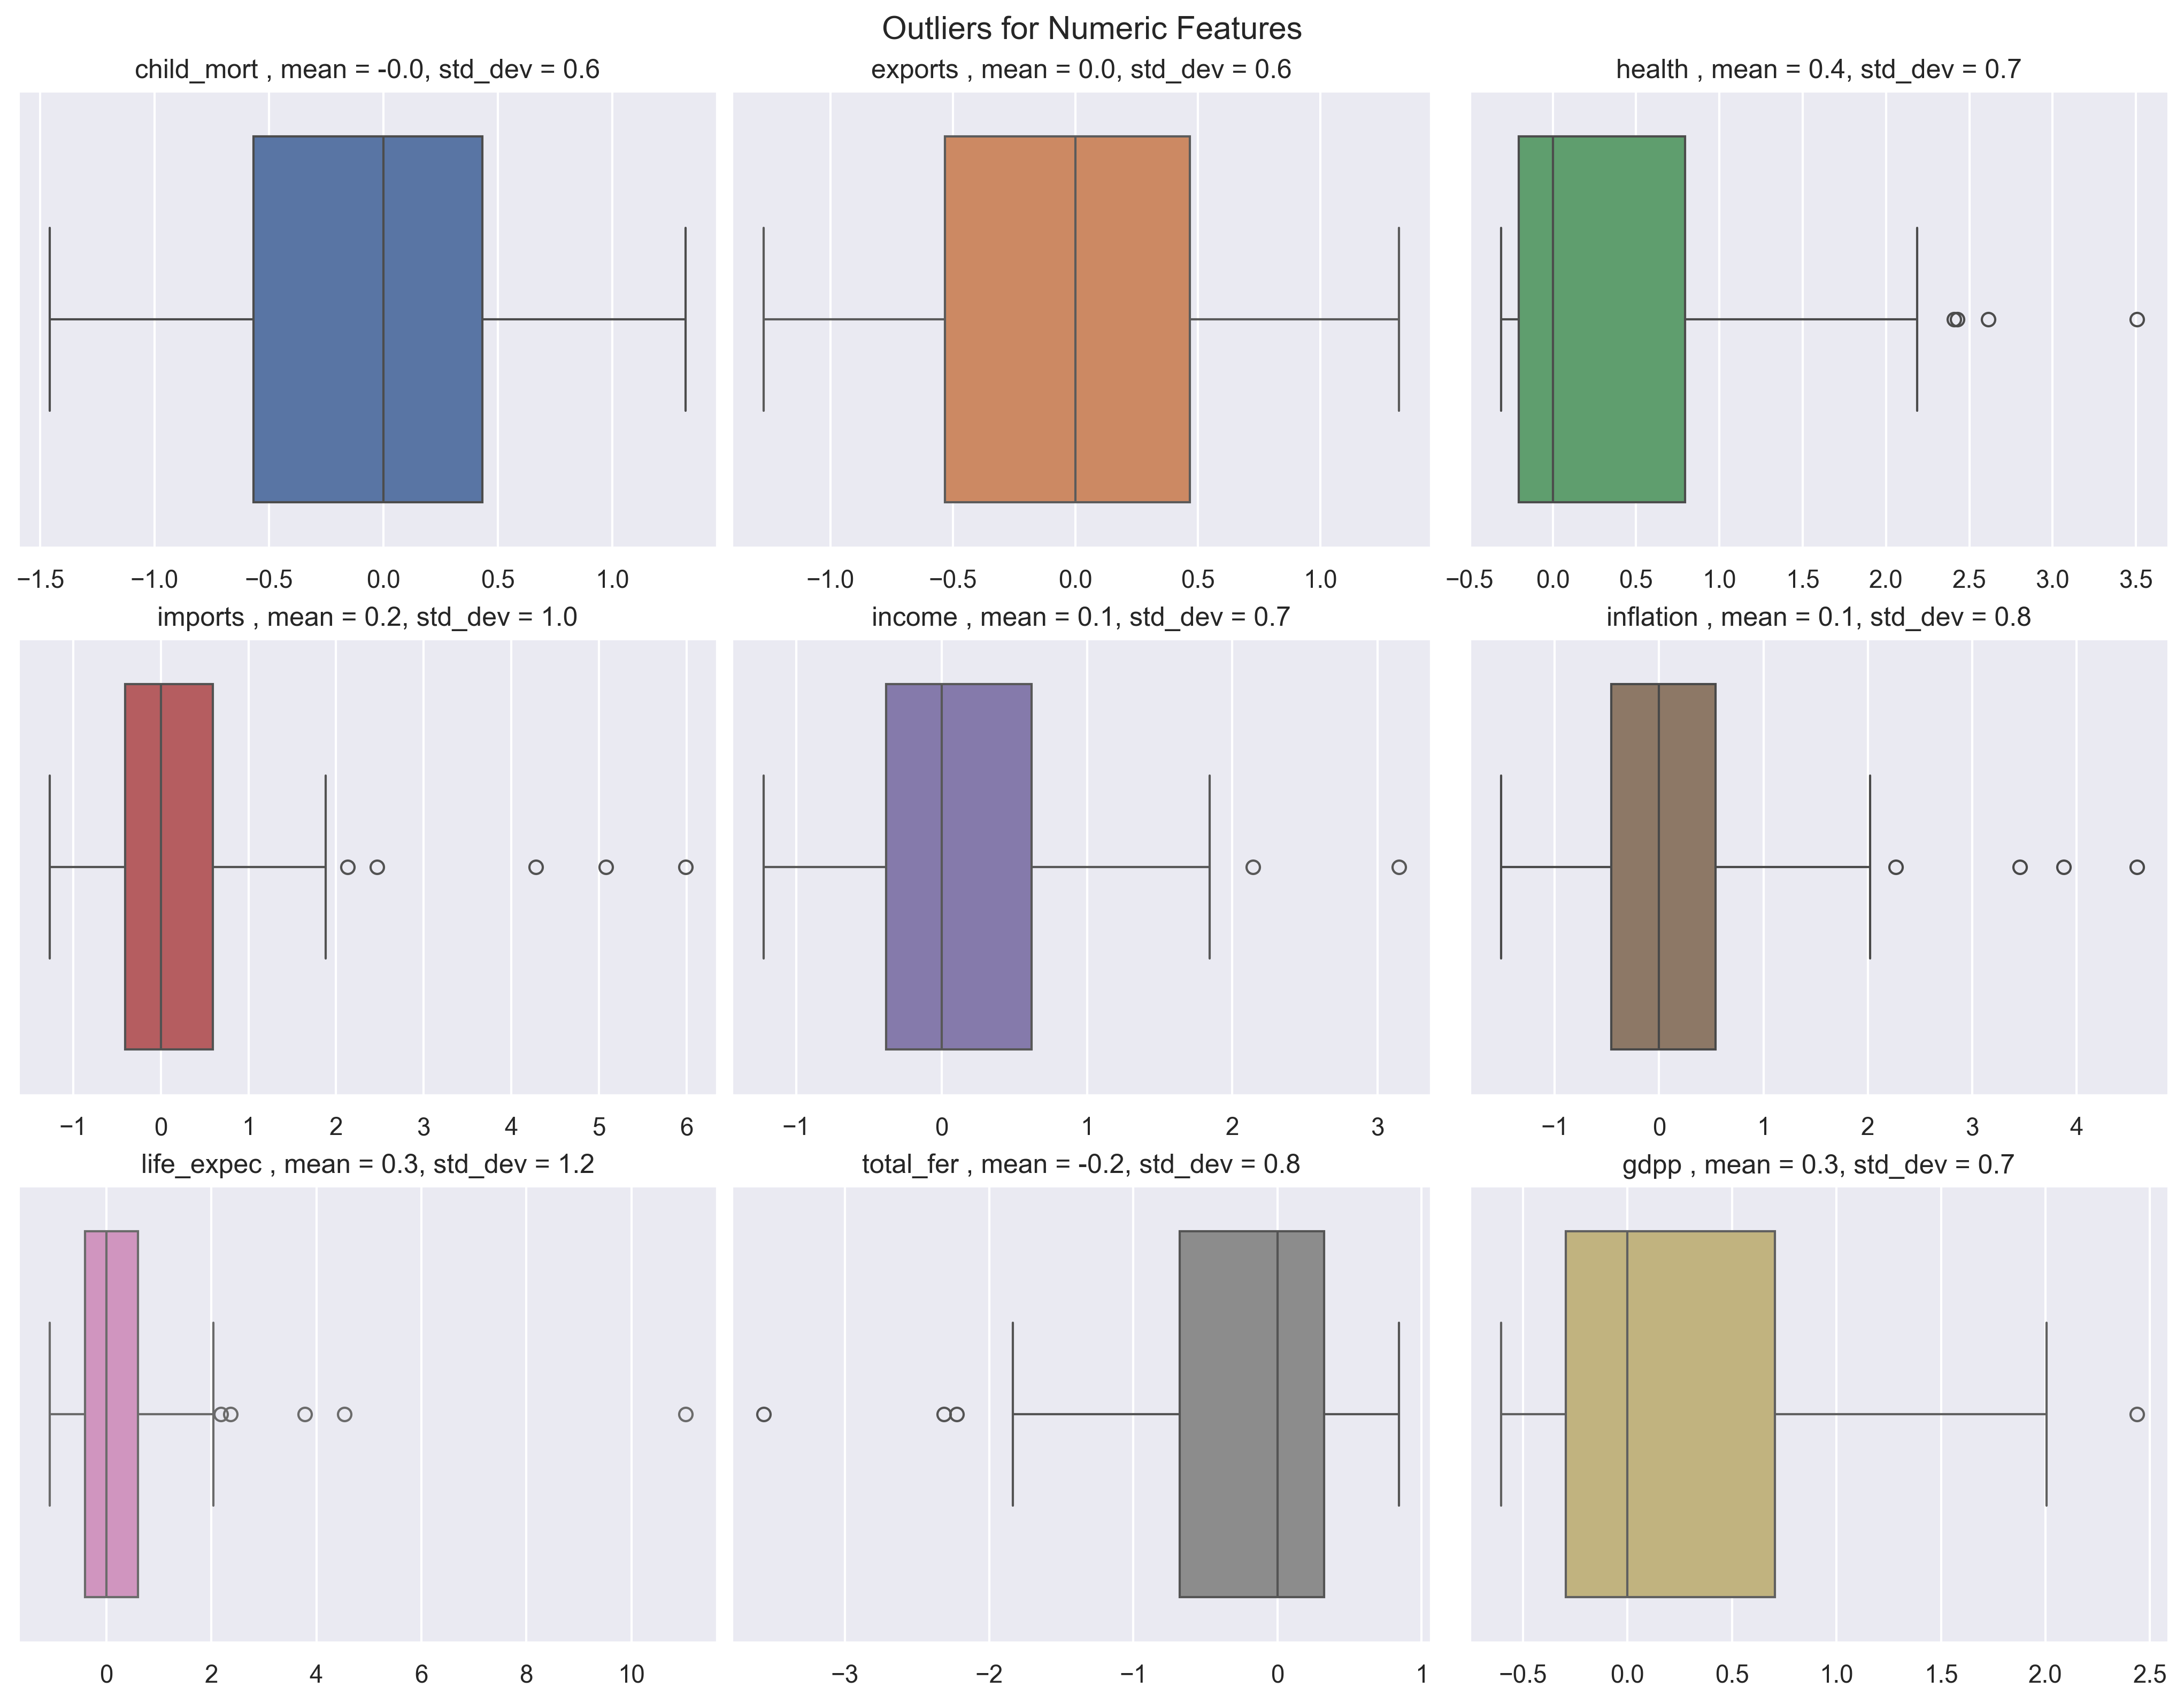

In [103]:
# Initially thought I might want to play with the limits on a per-feature basis, but I think it's better to just use the same limits for all features.'
feature_limits = {
    0: (0.05, 0.05), # child_mort
    1: (0.05, 0.05), # exports
    2: (0.05, 0.05), # health
    3: (0.05, 0.05), # imports
    4: (0.05, 0.05), # Income
    5: (0.05, 0.05), # Inflation
    6: (0.05, 0.05), # life_expectancy
    7: (0.05, 0.05), # total_fer
    8: (0.05, 0.05), # gdpp
}

def log_transform_safe(X):
    """Apply log1p transformation safely"""
    return np.log1p(np.maximum(X, 0))

# Create column transformer for selective log transformation
log_cols = ['income', 'gdpp']
other_cols = [col for col in num_cols if col not in log_cols]

column_transformer = ColumnTransformer([
    ('log_transform', FunctionTransformer(log_transform_safe), log_cols),
    ('passthrough', 'passthrough', other_cols)
], remainder='drop')

# PIpelne A with full outlier handling
scaler_A = Pipeline([
    ('log_transform', column_transformer),
    ('winsorizer', Winsorizer(feature_limits=feature_limits)),
    ('scaler', RobustScaler())
])

# Pipeline B with no Winsorisation
scaler_B = Pipeline([
    ('log_transform', column_transformer),
    ('scaler', RobustScaler())
])

scaled_A = scaler_A.fit_transform(country_data[num_cols])
scaled_A_df = pd.DataFrame(scaled_A, columns=num_cols, index=country_data.index)

scaled_B = scaler_B.fit_transform(country_data[num_cols])
scaled_B_df = pd.DataFrame(scaled_B, columns=num_cols, index=country_data.index)

print("Comparison of outliers for scaler_A and scaler_B:\n")
plot_outliers(scaled_A_df)
plot_outliers(scaled_B_df)

## 4) Modelling
Now that we have two scaled datasets, we can try various approaches to clustering.
1) kMeans with and without PCA
2) Optimese the Number of Clusters
3) DBScan as an alternative
4) Hierarchical Clustering

Evaluation and Interpretation of these clustering approaches is key as my main objective is to compare performance and discover country groupings within the dataset.

### With scaled_A
I am going to assume that the best results will come using scaled_A, as this is the dataset with the most outliers removed. Then I will check the best clustering results using scaled_B.


In [104]:
data = scaled_A

Figure saved: figs/5510_mini_project/kmeans_optimization_comprehensive.png


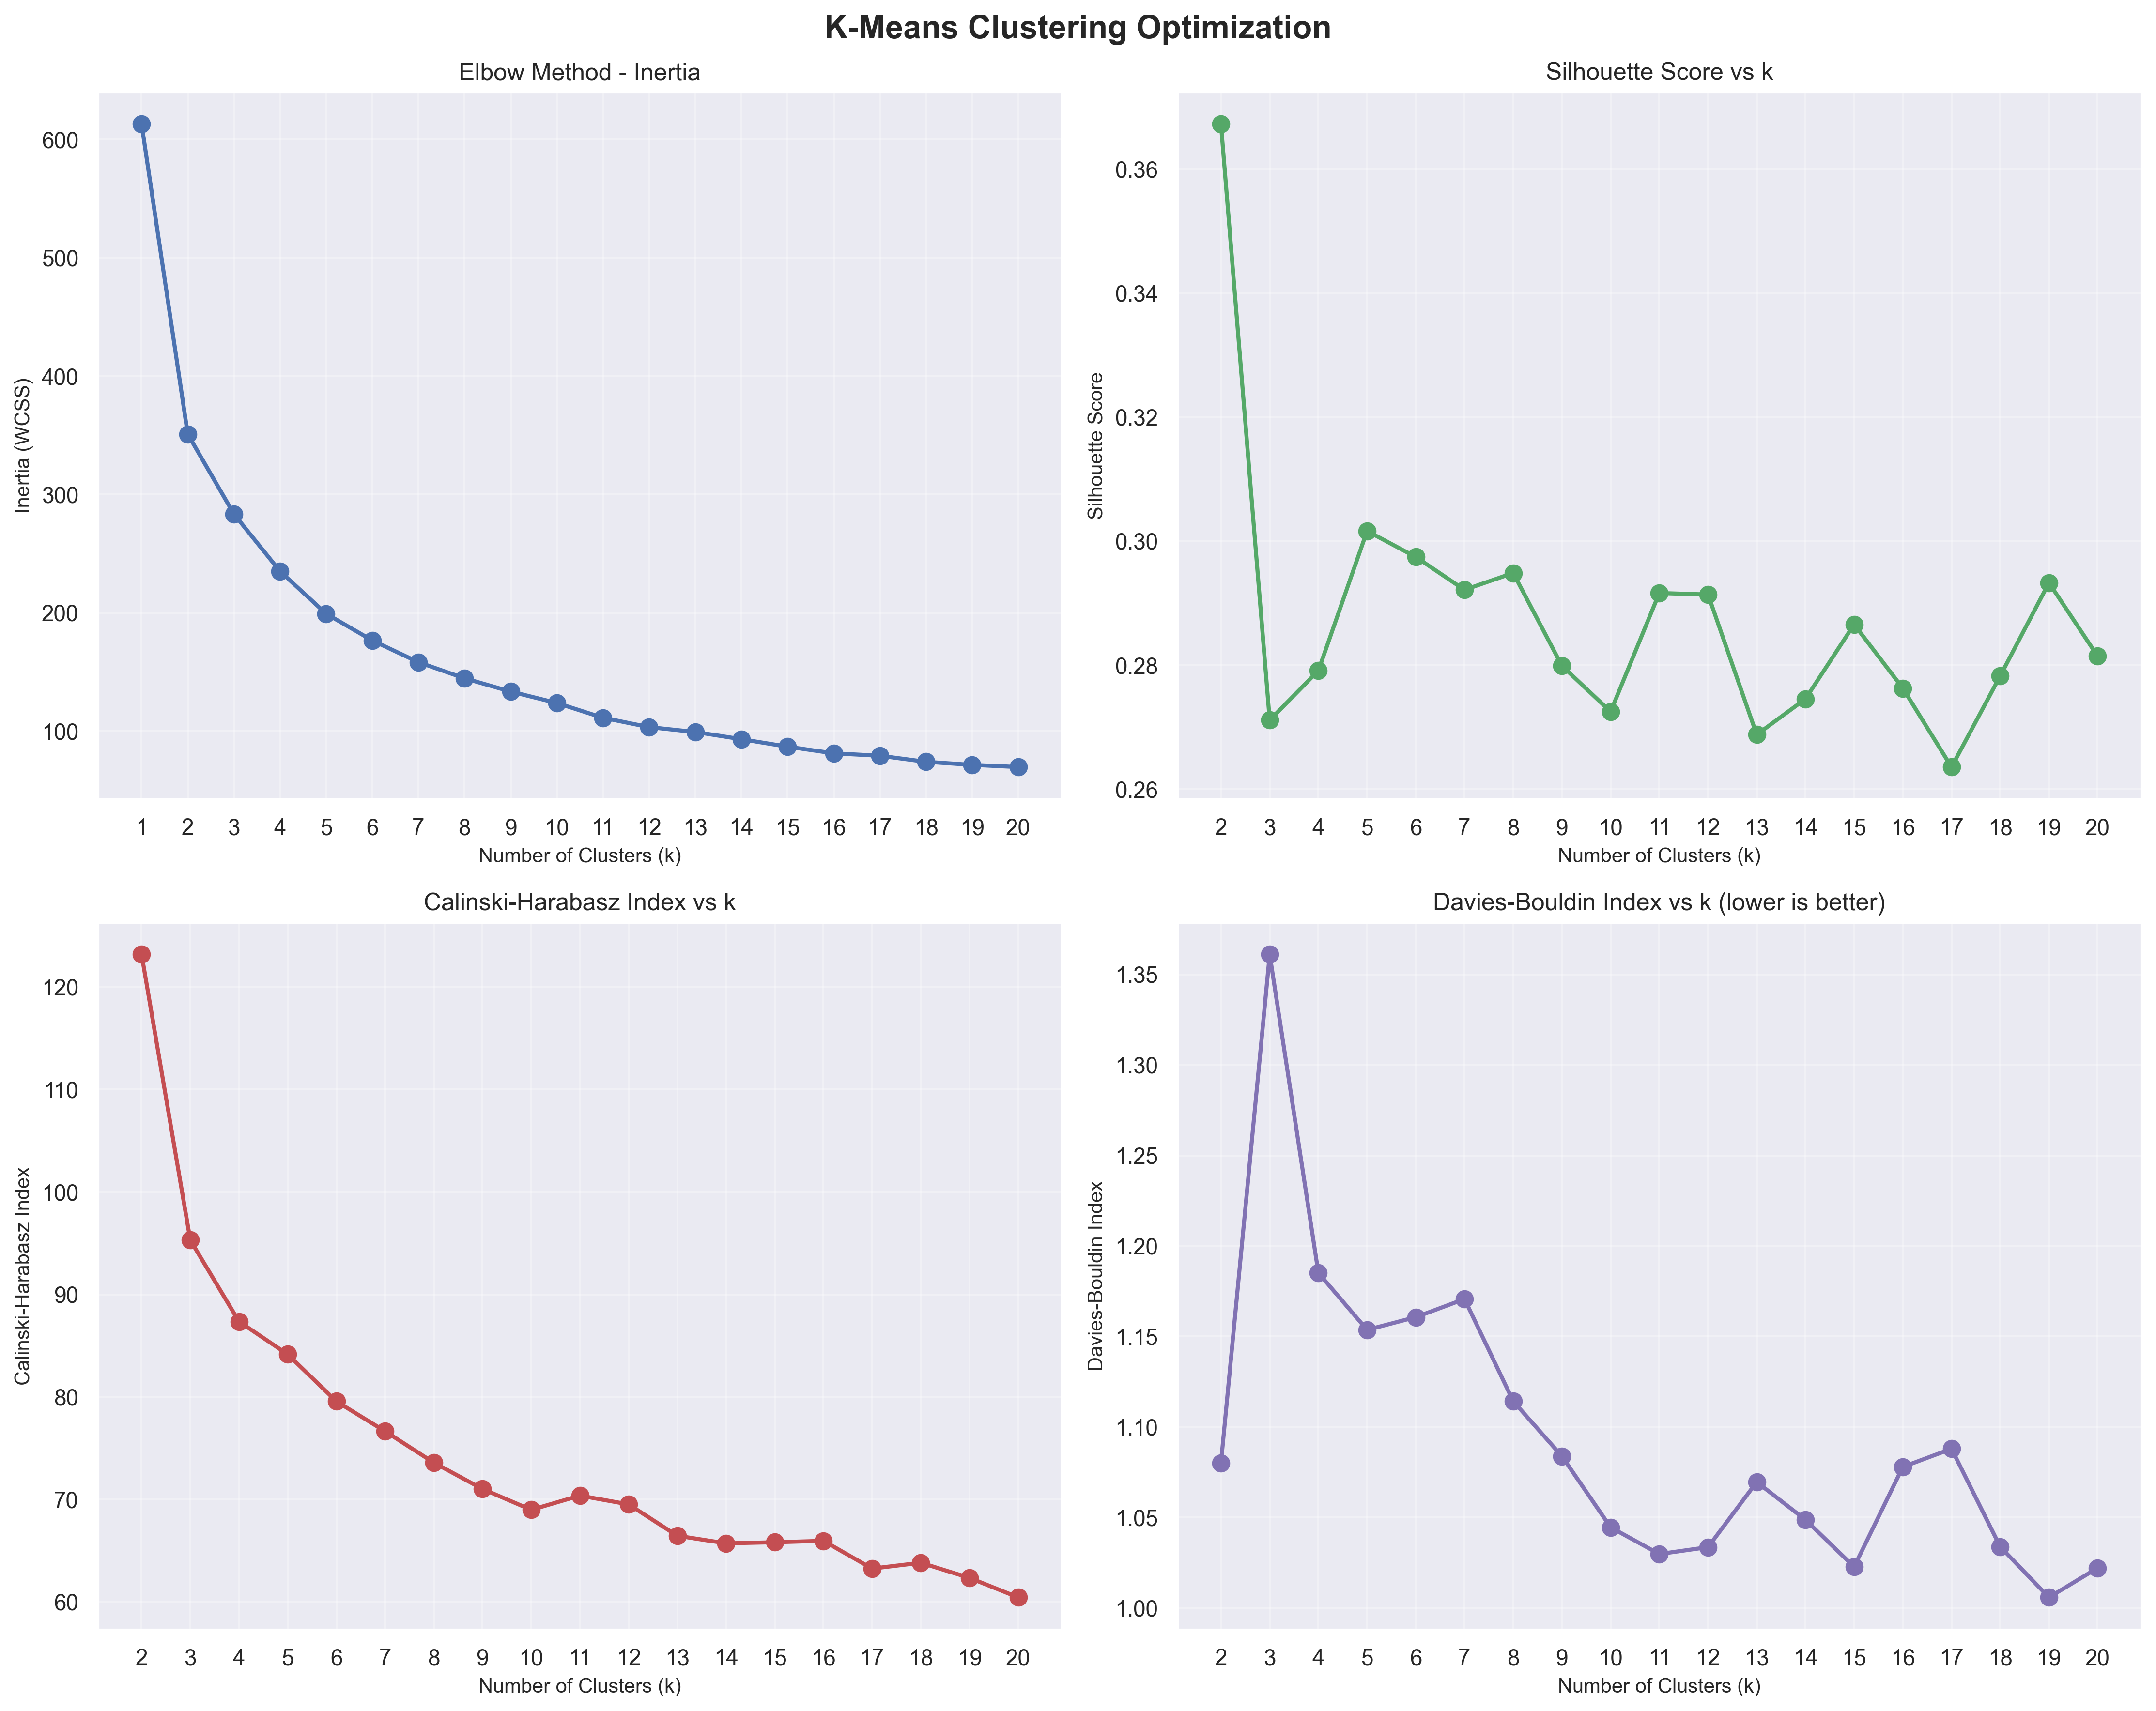

Cluster Optimization Summary:
Optimal k based on Silhouette Score: 2
Optimal k based on Calinski-Harabasz: 2
Optimal k based on Davies-Bouldin: 19


In [112]:
def evaluate_kmeans_clusters(data, k_range=range(1, 21), random_state=SEED):
    """
    Evaluate K-means clustering for different values of k
    Returns metrics for elbow method analysis
    """
    results = {
        'k': [],
        'inertia': [],
        'silhouette_score': [],
        'calinski_harabasz': [],
        'davies_bouldin': []
    }
    
    for k in k_range:
        # Create pipeline with current k
        pipeline = Pipeline([
            ('pca', PCA(n_components=0.9)),
            ('kmeans', KMeans(n_clusters=k, random_state=random_state, n_init=10))
        ])
        
        # Fit the pipeline
        pipeline.fit(data)
        
        # Get the fitted components
        kmeans = pipeline.named_steps['kmeans']
        pca_data = pipeline.named_steps['pca'].transform(data)
        labels = kmeans.labels_
        
        # Store results
        results['k'].append(k)
        results['inertia'].append(kmeans.inertia_)
        
        # Silhouette score (skip for k=1)
        if k > 1:
            results['silhouette_score'].append(silhouette_score(pca_data, labels))
            results['calinski_harabasz'].append(calinski_harabasz_score(pca_data, labels))
            results['davies_bouldin'].append(davies_bouldin_score(pca_data, labels))
        else:
            results['silhouette_score'].append(np.nan)
            results['calinski_harabasz'].append(np.nan)
            results['davies_bouldin'].append(np.nan)
    
    return results

def plot_elbow_charts(results, save_plots=True):
    """
    Plot comprehensive elbow method charts
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('K-Means Clustering Optimization', fontsize=16, fontweight='bold')
    
    # 1. Inertia (WCSS) - Traditional Elbow Method
    axes[0, 0].plot(results['k'], results['inertia'], 'bo-', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Number of Clusters (k)')
    axes[0, 0].set_ylabel('Inertia (WCSS)')
    axes[0, 0].set_title('Elbow Method - Inertia')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xticks(results['k'])
    
    # 2. Silhouette Score
    k_values = [k for k, score in zip(results['k'], results['silhouette_score']) if not np.isnan(score)]
    silhouette_values = [score for score in results['silhouette_score'] if not np.isnan(score)]
    
    axes[0, 1].plot(k_values, silhouette_values, 'go-', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('Number of Clusters (k)')
    axes[0, 1].set_ylabel('Silhouette Score')
    axes[0, 1].set_title('Silhouette Score vs k')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xticks(k_values)
    
    # 3. Calinski-Harabasz Index
    ch_values = [score for score in results['calinski_harabasz'] if not np.isnan(score)]
    axes[1, 0].plot(k_values, ch_values, 'ro-', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Number of Clusters (k)')
    axes[1, 0].set_ylabel('Calinski-Harabasz Index')
    axes[1, 0].set_title('Calinski-Harabasz Index vs k')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xticks(k_values)
    
    # 4. Davies-Bouldin Index (lower is better)
    db_values = [score for score in results['davies_bouldin'] if not np.isnan(score)]
    axes[1, 1].plot(k_values, db_values, 'mo-', linewidth=2, markersize=8)
    axes[1, 1].set_xlabel('Number of Clusters (k)')
    axes[1, 1].set_ylabel('Davies-Bouldin Index')
    axes[1, 1].set_title('Davies-Bouldin Index vs k (lower is better)')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xticks(k_values)
    
    plt.tight_layout()
    if save_plots:
        save_figure('kmeans_optimization_comprehensive')
    plt.show()
    
    # Print summary
    print("Cluster Optimization Summary:")
    print("=" * 50)
    
    # Find optimal k for each metric
    optimal_silhouette = k_values[np.argmax(silhouette_values)]
    optimal_ch = k_values[np.argmax(ch_values)]
    optimal_db = k_values[np.argmin(db_values)]
    
    print(f"Optimal k based on Silhouette Score: {optimal_silhouette}")
    print(f"Optimal k based on Calinski-Harabasz: {optimal_ch}")
    print(f"Optimal k based on Davies-Bouldin: {optimal_db}")



# Run the evaluation
cluster_results = evaluate_kmeans_clusters(data, k_range=range(1, 21))
# Create the plots
plot_elbow_charts(cluster_results)



Figure saved: figs/5510_mini_project/kmeans_clusters_pca_key_labels.png


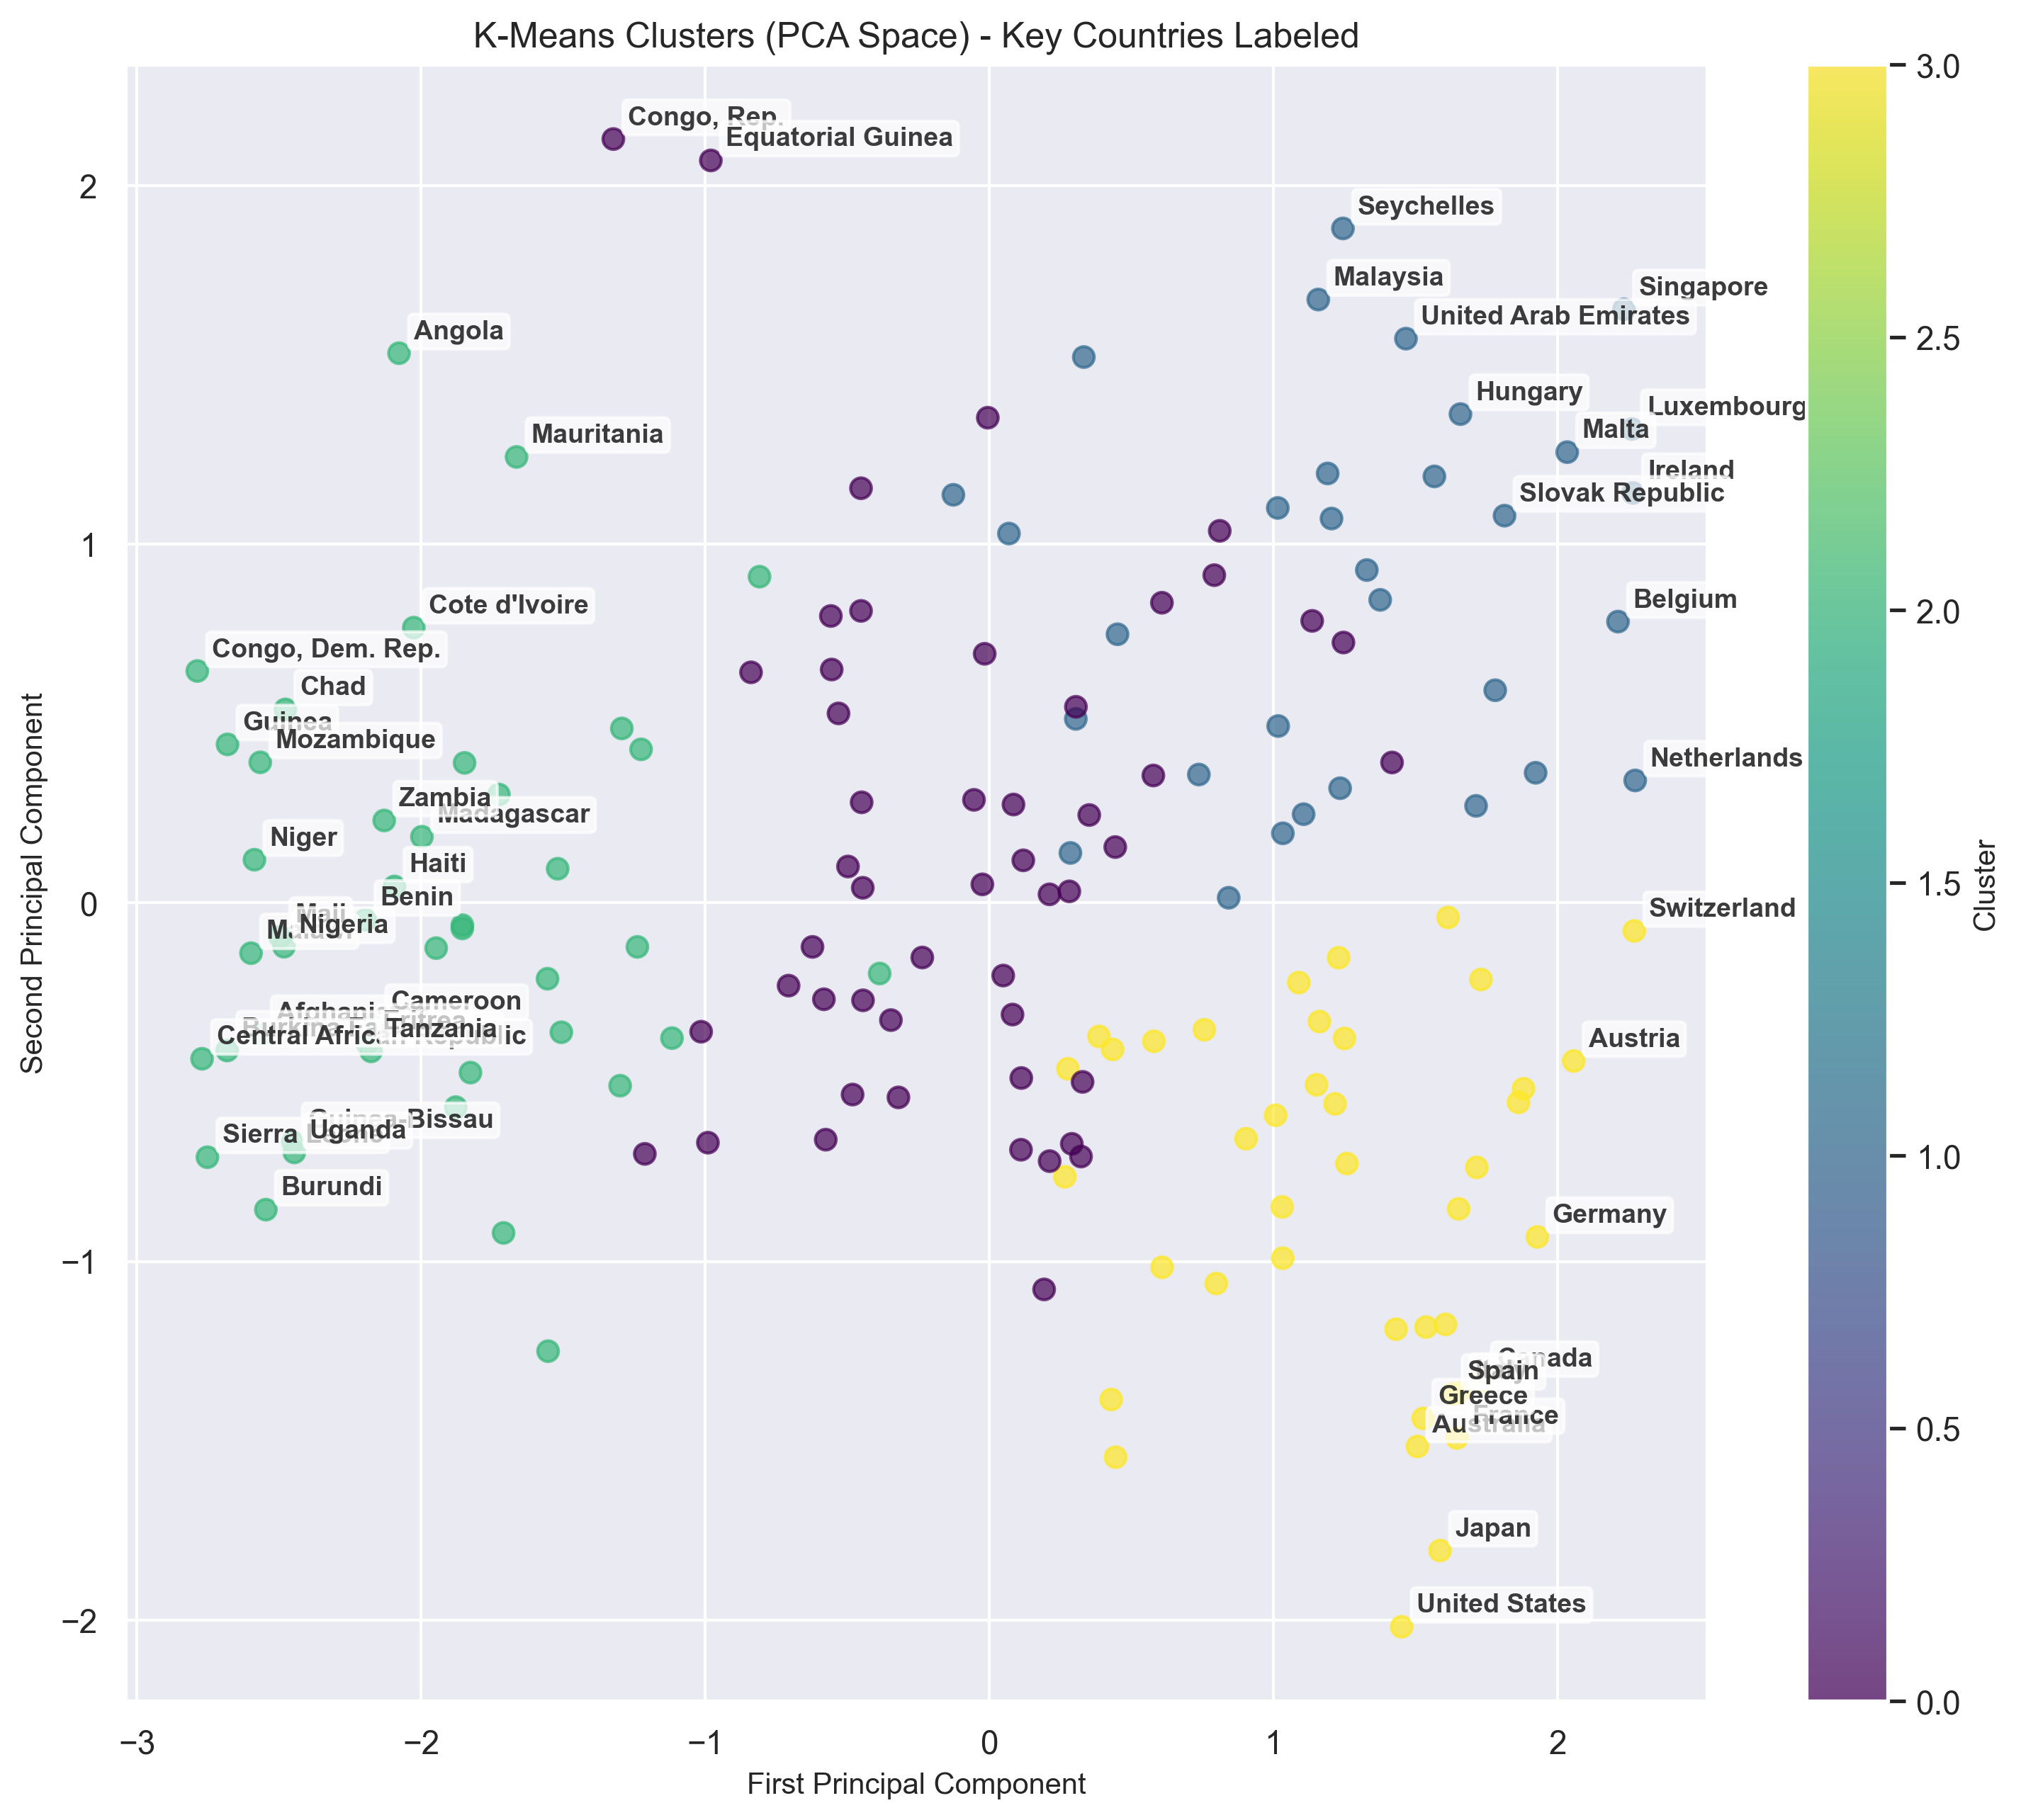

In [130]:
optimal_k = 4

kMeans_pipeline = Pipeline([
            ('pca', PCA(n_components=0.9)),
            ('kmeans', KMeans(n_clusters=optimal_k, random_state=SEED, n_init=10))
        ])

results = kMeans_pipeline.fit(data)

# Get cluster labels from your pipeline
labels = kMeans_pipeline.named_steps['kmeans'].labels_

# Create a scatter plot using the first 2 PCA components
pca_data = kMeans_pipeline.named_steps['pca'].transform(data)
plt.figure(figsize=(12, 10))
scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis', alpha=0.7, s=50)
plt.colorbar(scatter, label='Cluster')

# Label only countries that are far from the center or at extremes
for i, country in enumerate(country_data['country']):
    x, y = pca_data[i, 0], pca_data[i, 1]

    # Label if point is far from origin or at extremes
    distance_from_origin = np.sqrt(x**2 + y**2)
    if (distance_from_origin > 2 or
        abs(x) > 2.5 or abs(y) > 2.5):
        plt.annotate(country, (x, y),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, fontweight='bold', alpha=0.9,
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('K-Means Clusters (PCA Space) - Key Countries Labeled')
save_figure('kmeans_clusters_pca_key_labels')
plt.show()

In [121]:
def interpret_pca_components(pipeline, original_features, n_components_to_show=3):
    """
    Interpret PCA components by analyzing feature loadings
    """
    pca = pipeline.named_steps['pca']

    # Get the components (loadings)
    components = pca.components_

    # Create a DataFrame for easier interpretation
    loadings_df = pd.DataFrame(
        components[:n_components_to_show].T,
        columns=[f'PC{i+1}' for i in range(n_components_to_show)],
        index=original_features
    )

    print("PCA Component Loadings:")
    print("=" * 50)
    display(loadings_df.round(3))

    # Explained variance ratio
    print(f"\nExplained Variance Ratio:")
    for i, var_ratio in enumerate(pca.explained_variance_ratio_[:n_components_to_show]):
        print(f"PC{i+1}: {var_ratio:.3f} ({var_ratio*100:.1f}%)")

    print(f"\nCumulative Explained Variance: {pca.explained_variance_ratio_[:n_components_to_show].sum():.3f}")

    return loadings_df

# Use with your pipeline
loadings_df = interpret_pca_components(kMeans_pipeline, num_cols, n_components_to_show=3)

PCA Component Loadings:


PC1    PC2    PC3
child_mort  0.382  0.001  0.207
exports     0.386 -0.043  0.131
health     -0.429  0.075 -0.095
imports     0.253  0.715  0.012
income      0.152 -0.385 -0.530
inflation   0.093  0.536 -0.498
life_expec -0.215  0.146  0.616
total_fer   0.442 -0.143  0.134
gdpp       -0.428  0.069 -0.061


Explained Variance Ratio:
PC1: 0.520 (52.0%)
PC2: 0.165 (16.5%)
PC3: 0.150 (15.0%)

Cumulative Explained Variance: 0.835


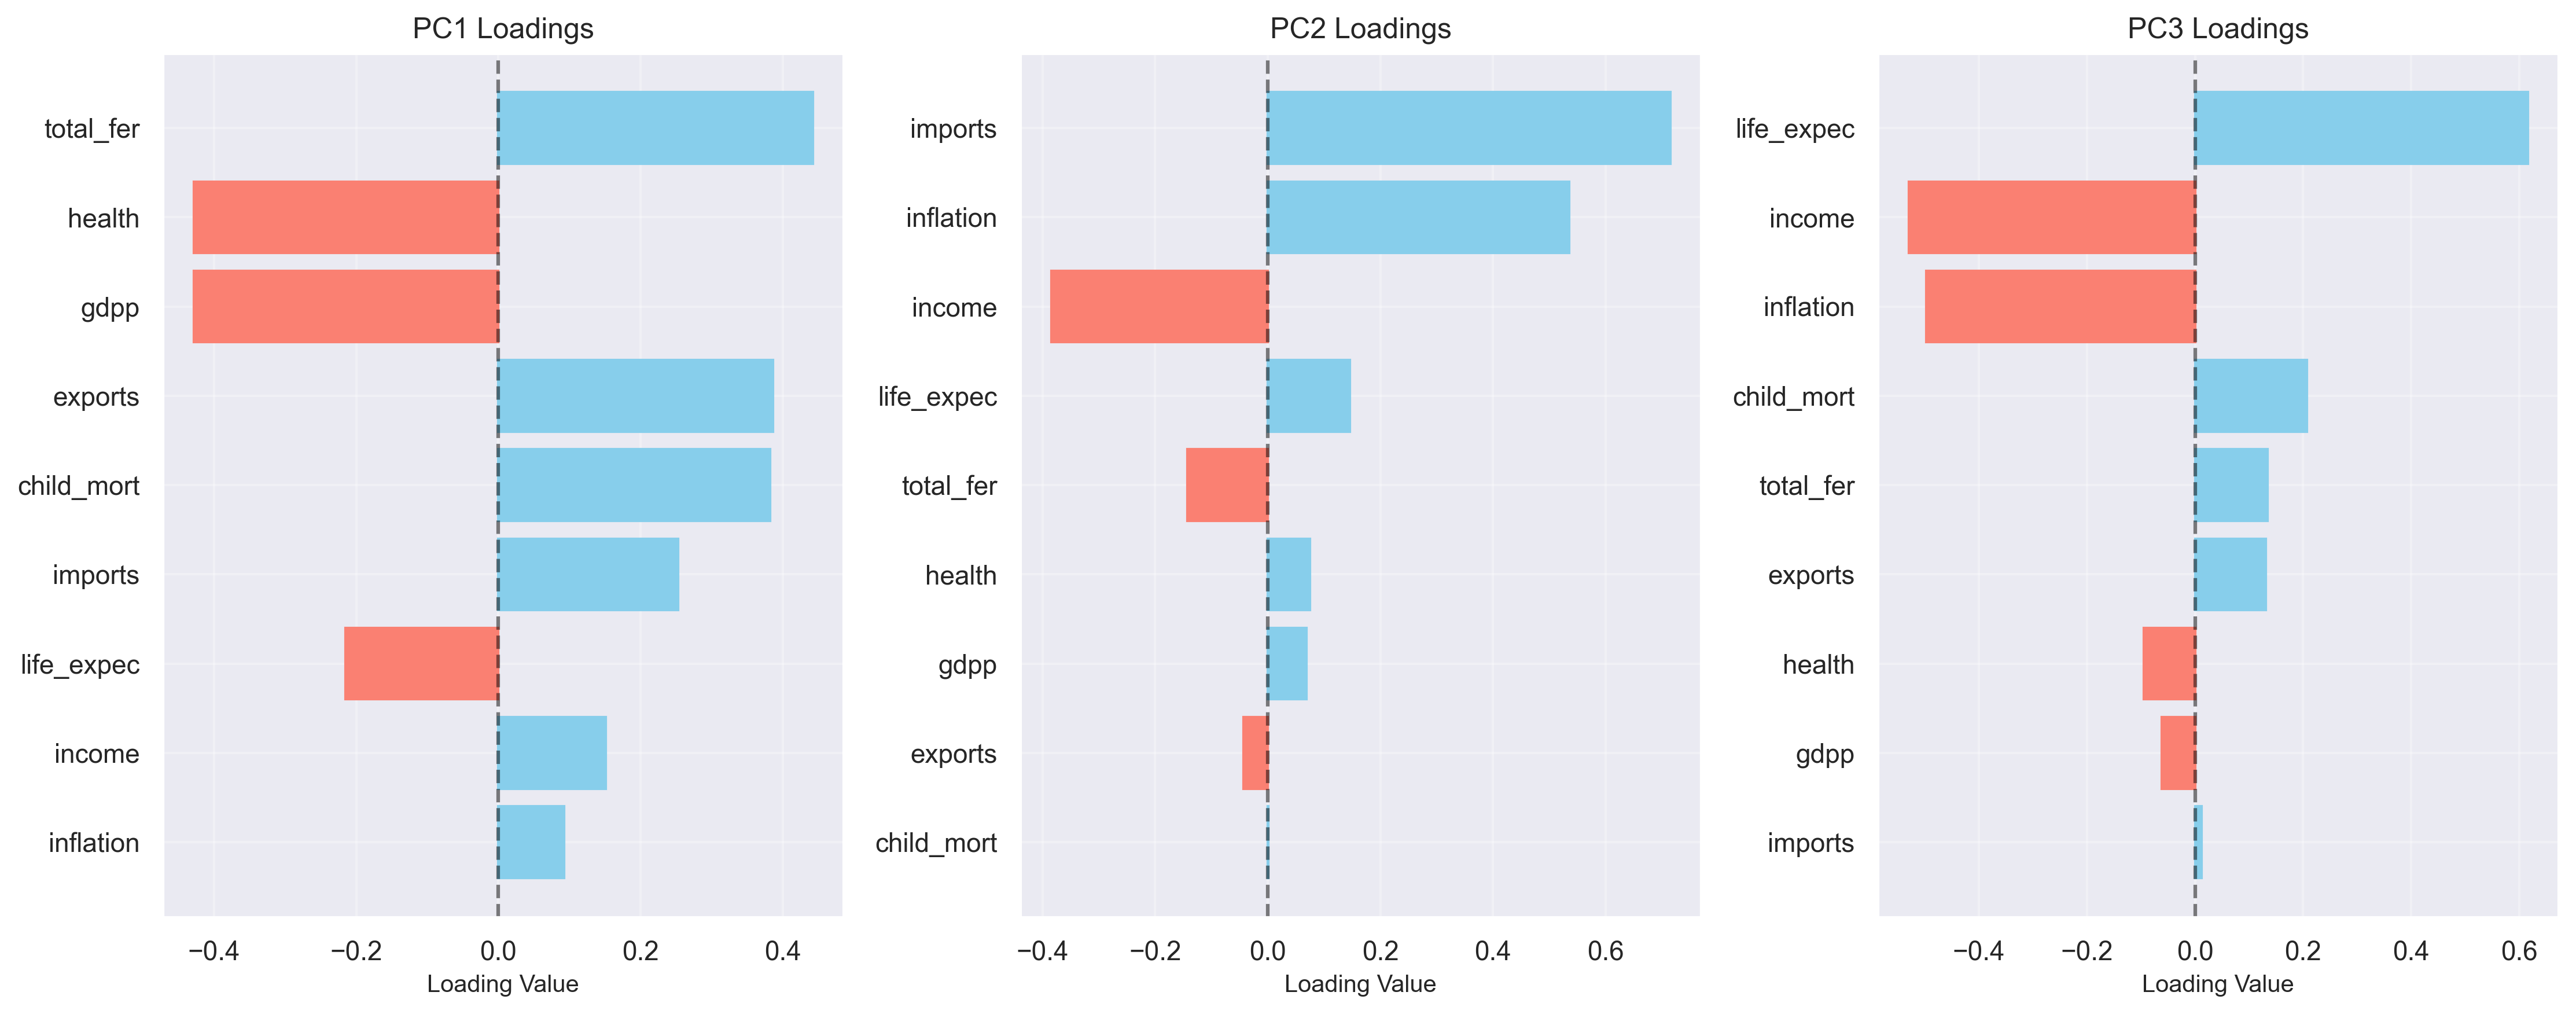

In [123]:
def plot_pca_loadings(loadings_df, explained_variance_ratio=None, n_components=None):
    """
    Plot PCA loadings for the first n components

    Parameters:
    loadings_df: DataFrame with PCA loadings
    explained_variance_ratio: Array of explained variance ratios from PCA
    n_components: Number of components to plot (default: all or first 4)
    """
    if n_components is None:
        n_components = min(4, loadings_df.shape[1])

    fig, axes = plt.subplots(1, n_components, figsize=(5*n_components, 6))
    if n_components == 1:
        axes = [axes]

    for i in range(n_components):
        pc = f'PC{i+1}'
        if pc not in loadings_df.columns:
            print(f"Warning: {pc} not found in loadings dataframe")
            continue

        loadings = loadings_df[pc].sort_values(key=abs, ascending=True)

        # Create horizontal bar plot
        bars = axes[i].barh(range(len(loadings)), loadings.values)

        # Color bars based on positive/negative
        for j, bar in enumerate(bars):
            if loadings.values[j] >= 0:
                bar.set_color('skyblue')
            else:
                bar.set_color('salmon')

        axes[i].set_yticks(range(len(loadings)))
        axes[i].set_yticklabels(loadings.index)
        axes[i].set_xlabel('Loading Value')

        # Build title - include explained variance if available
        title = f'{pc} Loadings'
        if explained_variance_ratio is not None and i < len(explained_variance_ratio):
            title += f'\n(Explained Var: {explained_variance_ratio[i]:.1%})'
        axes[i].set_title(title)

        axes[i].axvline(x=0, color='black', linestyle='--', alpha=0.5)
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Create the visualization - you'll need to update this call
# Assuming you have a pca_model object from your PCA analysis
# plot_pca_loadings(loadings_df, explained_variance_ratio=pca_model.explained_variance_ratio_)

# If you don't have the PCA object, you can call it without explained variance:
plot_pca_loadings(loadings_df)

Figure saved: figs/5510_mini_project/pca_biplot_pc1_pc2.png


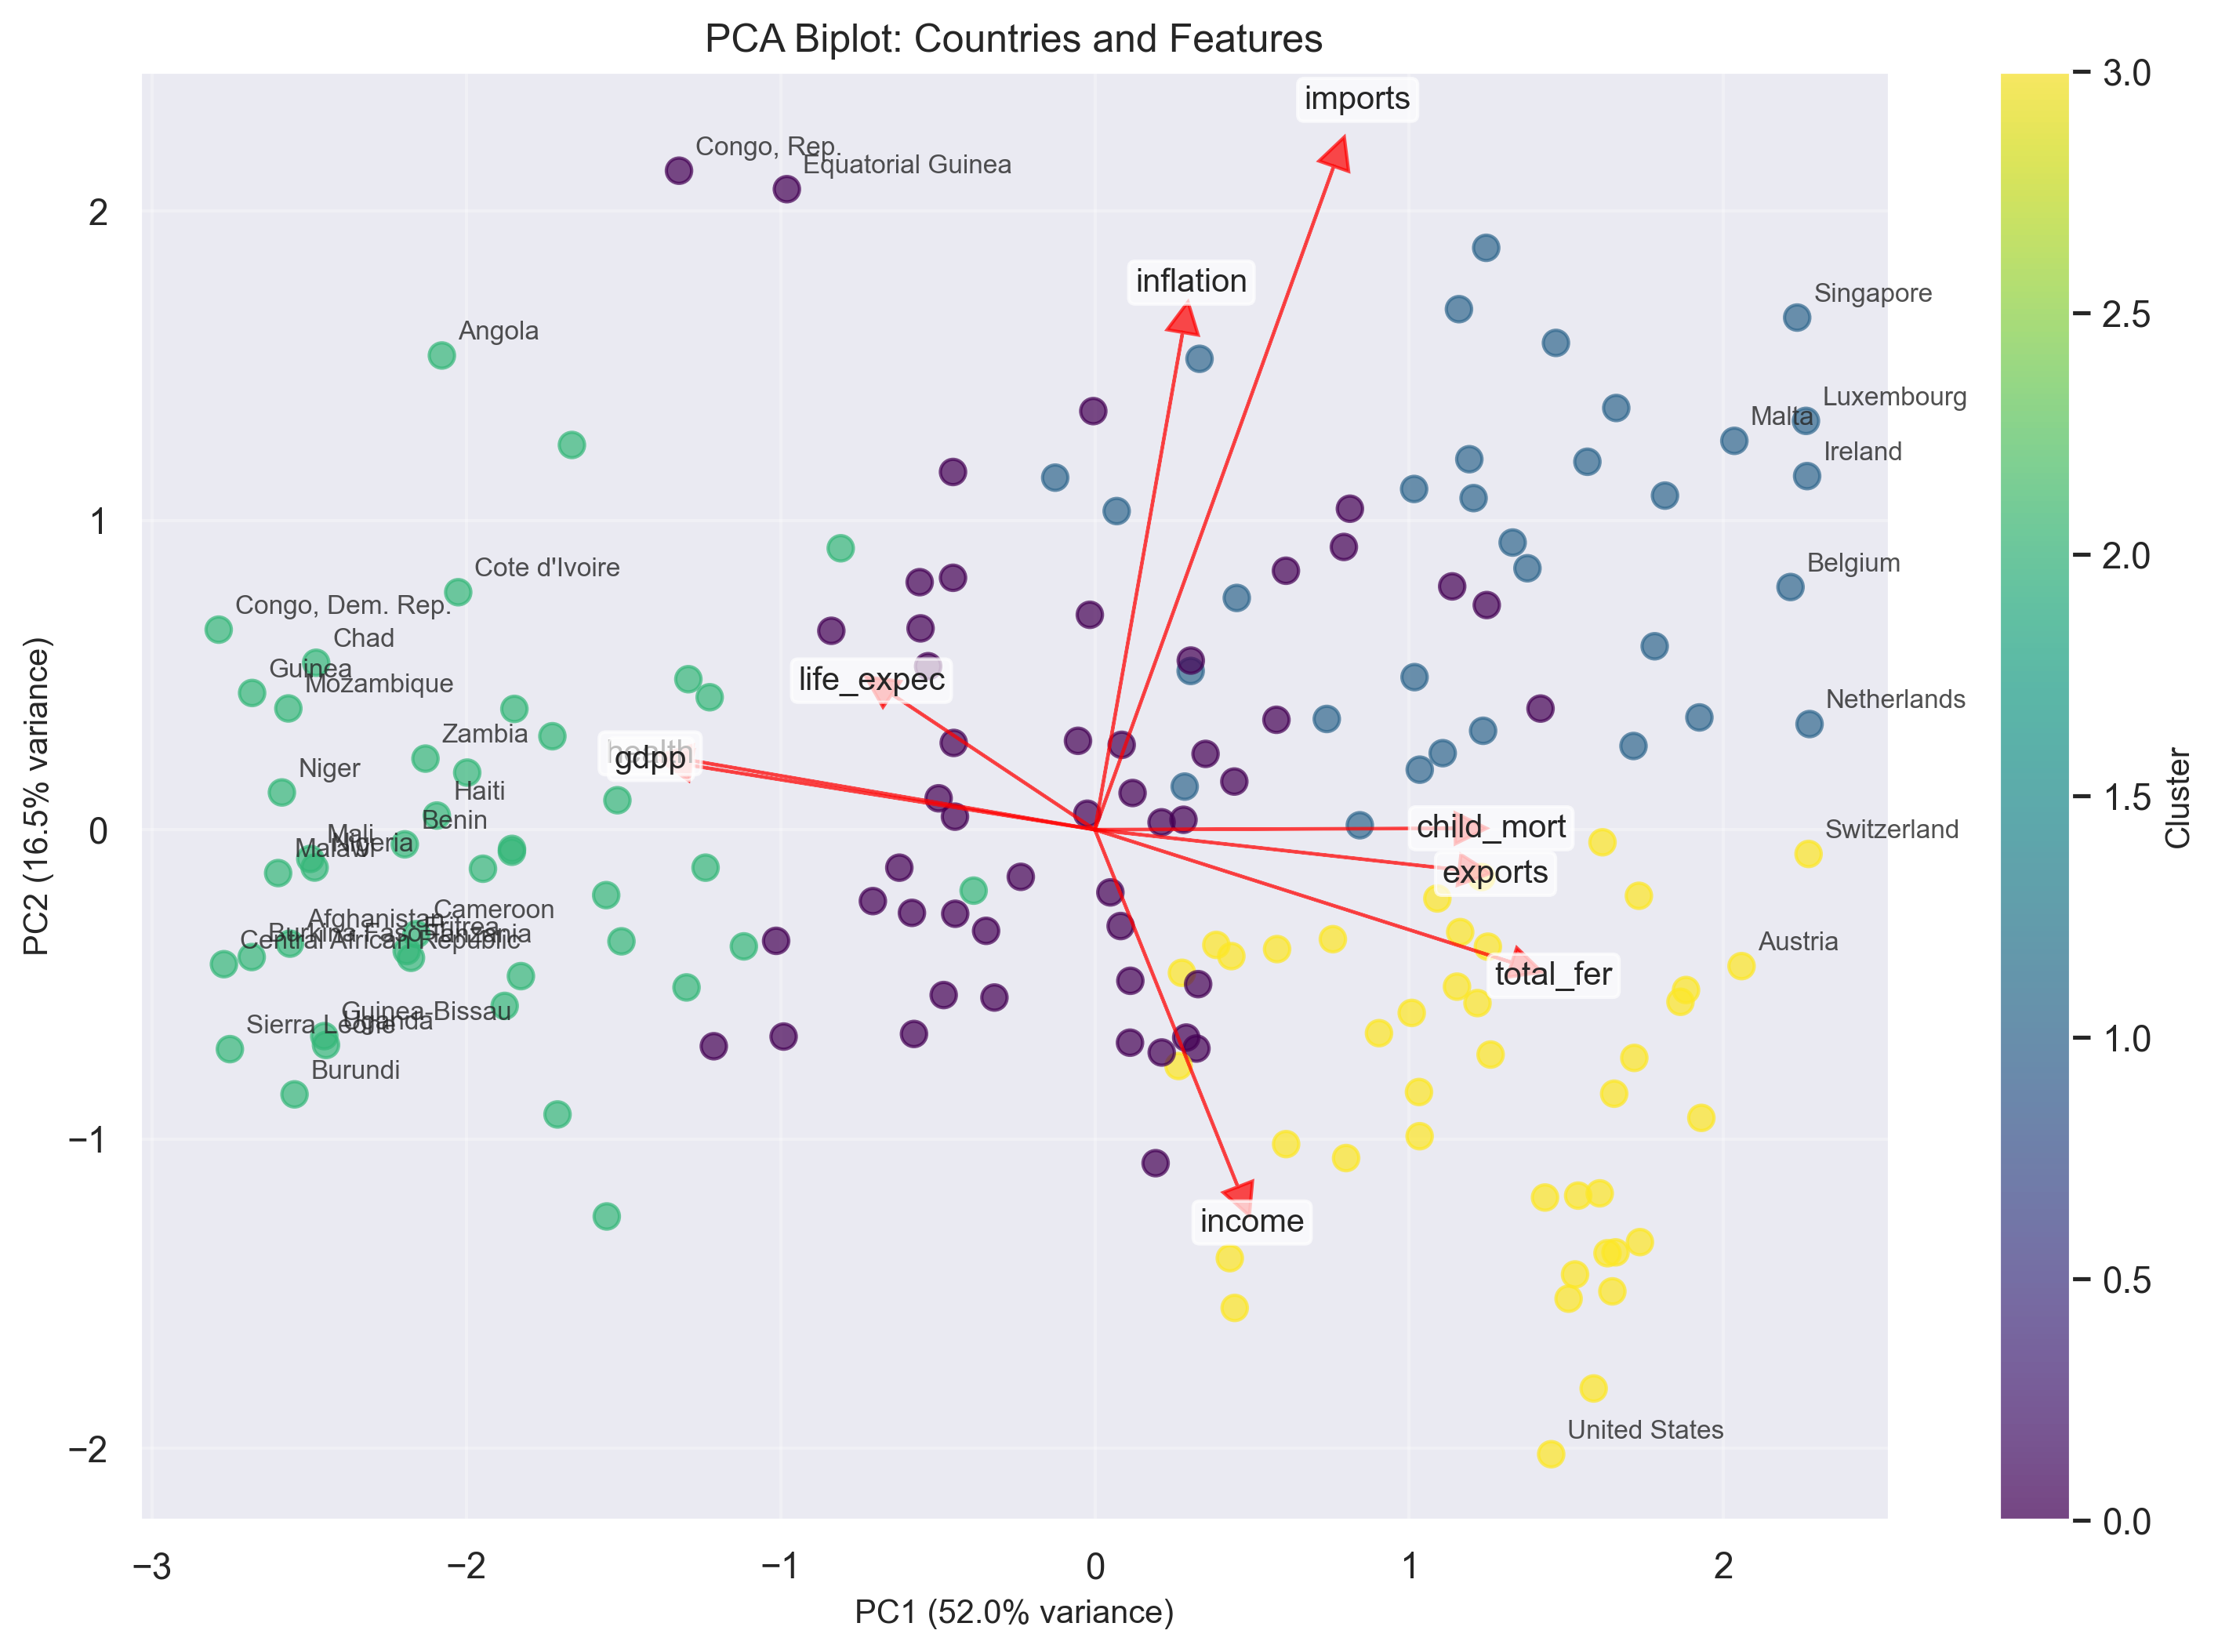

In [124]:

def create_pca_biplot(pca_pipeline, data, country_data, feature_names, pc1=0, pc2=1):
    """
    Create a PCA biplot showing both observations and feature vectors
    """
    pca = pca_pipeline.named_steps['pca']
    pca_data = pca.transform(data)

    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot country points
    labels = pca_pipeline.named_steps['kmeans'].labels_
    scatter = ax.scatter(pca_data[:, pc1], pca_data[:, pc2],
                        c=labels, cmap='viridis', alpha=0.7, s=60)

    # Add country labels for interesting points
    for i, country in enumerate(country_data['country']):
        # Only label points that are far from origin or represent extremes
        if abs(pca_data[i, pc1]) > 2 or abs(pca_data[i, pc2]) > 2:
            ax.annotate(country, (pca_data[i, pc1], pca_data[i, pc2]),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, alpha=0.8)

    # Plot feature vectors (loadings)
    loadings = pca.components_
    scaling_factor = 3  # Adjust this to make arrows visible

    for i, feature in enumerate(feature_names):
        ax.arrow(0, 0,
                loadings[pc1, i] * scaling_factor,
                loadings[pc2, i] * scaling_factor,
                head_width=0.1, head_length=0.1,
                fc='red', ec='red', alpha=0.7)
        ax.text(loadings[pc1, i] * scaling_factor * 1.1,
                loadings[pc2, i] * scaling_factor * 1.1,
                feature, fontsize=10, ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))

    ax.set_xlabel(f'PC{pc1+1} ({pca.explained_variance_ratio_[pc1]:.1%} variance)')
    ax.set_ylabel(f'PC{pc2+1} ({pca.explained_variance_ratio_[pc2]:.1%} variance)')
    ax.set_title('PCA Biplot: Countries and Features')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, label='Cluster')

    save_figure(f'pca_biplot_pc{pc1+1}_pc{pc2+1}')
    plt.show()

# Create the biplot
create_pca_biplot(kMeans_pipeline, data, country_data, num_cols)

In [125]:

def analyze_clusters(country_data, labels, features_to_analyze=None):
    """
    Analyze cluster characteristics in original feature space
    """
    if features_to_analyze is None:
        features_to_analyze = num_cols

    # Add cluster labels to country data
    analysis_df = country_data.copy()
    analysis_df['Cluster'] = labels

    print("=== Cluster Analysis ===")

    # Show cluster sizes
    cluster_counts = analysis_df['Cluster'].value_counts().sort_index()
    print(f"\nCluster sizes:")
    for cluster, count in cluster_counts.items():
        print(f"Cluster {cluster}: {count} countries")

    # Calculate cluster means for each feature
    cluster_means = analysis_df.groupby('Cluster')[features_to_analyze].mean()

    print(f"\nCluster characteristics (means):")
    display(cluster_means.round(2))

    # Show some example countries from each cluster
    print(f"\nExample countries per cluster:")
    for cluster in sorted(analysis_df['Cluster'].unique()):
        cluster_countries = analysis_df[analysis_df['Cluster'] == cluster]['country'].head(5).tolist()
        print(f"Cluster {cluster}: {', '.join(cluster_countries)}")

    return analysis_df, cluster_means

# Analyze your clusters
cluster_analysis_df, cluster_means = analyze_clusters(country_data, labels)

=== Cluster Analysis ===

Cluster sizes:
Cluster 0: 50 countries
Cluster 1: 32 countries
Cluster 2: 44 countries
Cluster 3: 41 countries

Cluster characteristics (means):


child_mort  exports  health  imports    income  inflation  \
Cluster                                                              
0             31.61    40.54    4.95    38.85  16832.60      11.68   
1             11.27    75.57    6.88    76.16  25485.62       3.05   
2             93.16    24.53    6.62    44.10   2130.98      11.49   
3              8.57    32.70    9.25    36.85  27127.56       2.75   

         life_expec  total_fer      gdpp  
Cluster                                   
0             70.29       2.74   8075.64  
1             75.72       1.88  18965.62  
2             59.67       5.03    998.23  
3             78.53       1.81  27083.17


Example countries per cluster:
Cluster 0: Algeria, Argentina, Armenia, Azerbaijan, Bangladesh
Cluster 1: Antigua and Barbuda, Bahrain, Belgium, Belize, Bulgaria
Cluster 2: Afghanistan, Angola, Benin, Burkina Faso, Burundi
Cluster 3: Albania, Australia, Austria, Bahamas, Barbados


In [126]:

def print_cluster_membership(country_data, labels, cluster_names=None):
    """
    Print cluster membership showing which countries belong to each cluster

    Parameters:
    country_data: DataFrame with country information
    labels: Array of cluster labels from your clustering model
    cluster_names: Optional dict to map cluster numbers to meaningful names
    """
    # Create a copy to avoid modifying original data
    membership_df = country_data[['country']].copy()
    membership_df['Cluster'] = labels

    print("=== CLUSTER MEMBERSHIP ===")
    print(f"Total countries: {len(membership_df)}")

    # Get unique clusters and sort them
    unique_clusters = sorted(membership_df['Cluster'].unique())

    for cluster_id in unique_clusters:
        cluster_countries = membership_df[membership_df['Cluster'] == cluster_id]['country'].tolist()
        cluster_size = len(cluster_countries)

        # Use custom name if provided, otherwise use cluster number
        if cluster_names and cluster_id in cluster_names:
            cluster_name = f"Cluster {cluster_id} ({cluster_names[cluster_id]})"
        else:
            cluster_name = f"Cluster {cluster_id}"

        print(f"\n{cluster_name} - {cluster_size} countries:")
        print("-" * (len(cluster_name) + 15))

        # Print countries in a nice format (3 columns)
        for i in range(0, len(cluster_countries), 3):
            row_countries = cluster_countries[i:i+3]
            print("  " + "  |  ".join(f"{country:<20}" for country in row_countries))

# Basic usage with your existing variables
print_cluster_membership(country_data, labels)

=== CLUSTER MEMBERSHIP ===
Total countries: 167

Cluster 0 - 50 countries:
------------------------
  Algeria               |  Argentina             |  Armenia             
  Azerbaijan            |  Bangladesh            |  Belarus             
  Bhutan                |  Bolivia               |  Botswana            
  Brunei                |  Cambodia              |  Cape Verde          
  China                 |  Congo, Rep.           |  Dominican Republic  
  Egypt                 |  Equatorial Guinea     |  Gabon               
  Guatemala             |  India                 |  Indonesia           
  Iran                  |  Iraq                  |  Jamaica             
  Kazakhstan            |  Kuwait                |  Kyrgyz Republic     
  Libya                 |  Mongolia              |  Morocco             
  Myanmar               |  Namibia               |  Oman                
  Paraguay              |  Peru                  |  Philippines         
  Qatar                 